## Introduction

Article citations and views are hot commodities. They are used to assess to assess the strength of scientific job applicants, score the "impact" of journals, and boost advertising revenue[<sup>1</sup>](https://www.ajronline.org/doi/full/10.2214/AJR.16.17769)<sup>,</sup>[<sup>2</sup>](https://partnerships.nature.com/blog/life-sciences-audience/). Is there a relationship between research quality and citations and views? Here, I take a first pass at examining whether the details of articles and peer reviews are predictive of these metrics. 

Elife is an open-access, open-review journal covering a range of topics in Biology. Being relatively new (founded in 2012), its publication process has been relatively consistent over the years. Elife articles therefore provide a rich dataset for examining whether article details and reviewer critiques predict how highly viewed and cited an article is. 


## Collecting articles and review text

Elife articles and reviewer decision letters are systematically organized and embedded in html. All research articles are hyperlinked from a set of contents pages. (Note that their formatting may change since the time of my collecting in June 2020. Additionally, these code blocks result in thousands of rapid url pulls from the same domain, which is very likely to result in the user's ISP address being blocked by the domain. If actually trying to run this code, please see further notes at end of notebook first.) I began by extracting the article hyperlinks:

In [ ]:
import requests # use the requests library to pull the content page urls
elifeListPageStart = 2   # 1st page to use for elife table of contents; seems consistent from page 2 onward to 754
elifeListPageEnd = 753 # currently claims to end at 754
elifeListPageUrlStart = 'https://elifesciences.org/?page=' # beginning of the url string for content page

listPageNums = range(elifeListPageStart,elifeListPageEnd+1,1)
listPages = []  # a list to store the 
for num in listPageNums:
    
    clear_output(wait=True) # clear the output during the loop so 
    
    url = elifeListPageUrlStart + str(num)
    listPages += [requests.get(url)]
    
    print("Downloaded page:",num)

listPages_text=[] # compile the request text for convenience (could probably have deleted the listPages data)
for request in listPages:
    listPages_text += [request.text]
    
print(listPages_text[3]) # print the text for an example (output later deleted for readability)

Extract the article hyperlinks from the content page htlm (using the Python regular expressions module): 

In [83]:
import re
linkStartStr = '<a href="/articles/' # appears to be specific to the links to articles
linksPerPage = 10 
articleNums = []
for text in listPages_text:
    links = re.findall(linkStartStr+'\S+', text)
    for link in links:
        linkTemp = link.replace(linkStartStr,'')
        linkTemp = linkTemp.replace('\"','')
        articleNums += [linkTemp]
    
print("articles found:",len(articleNums),"articles expected:",len(listPages_text)*linksPerPage)

articles found: 7520 articles expected: 7520


Download the articles and save each one to the hard drive before moving onto the next (this reduces the potential for data loss in case of a run-time issue):

In [ ]:
elifeListPageUrlStart = 'https://elifesciences.org/articles/' # each article is at a url like this, ending in the article number
articlesRequest = [] # list to hold the article request data
import pickle
for i, articleNum in enumerate(articleNums): 
    
    clear_output(wait=True)
    
    url = elifeListPageUrlStart + articleNum
    article = requests.get(url)
    articlesRequest += [article]
    with open('raw/' + articleNum + '.dat', 'wb') as fh: # we'll save the data in case something goes wrong.. of course what goes wrong could be running out of hard drive space, but it's just text!
        pickle.dump(article,fh) 
    
    print("Downloaded page:",articleNum,"% complete:",100*(i+1)/len(articleNums))

clear_output(wait=False)
print('')
print(articlesRequest[0].text) # print example text from an article (output cleared for readability)

# Data pre-processing

Define some functions using regular expressions to extract data from the article html:

In [2]:
def strExtract(fromStr, preStr, postStrs, **kwargs):
    """Returns the shortest string bounded by preStr and one or more postStrs found in fromStr
    Also returns the index after the end of the return region, which is useful for searching for another match in fromStr
    Passing returnInputExcision = True leads to a third returned parameter, fromStr with the matching region excised
    
    Keyword arguments:
    (bool) matchNewLine (default false) -- if True, re.search will treat /n is like other characters (instead of halting search ends at it)
    (bool) returnInputExcision (default false) -- if True, returns as a second output fromStr after excision of <preStr><extractedStr><postStr>
    (int) start (default 0) -- pass to start search at arbitrary point in fromStr
    (int) end (default len(fromStr)) -- pass to end search at artbitrary point in fromStr
    
    warnings/to do: no error handling for absence of preStr, absence of at least one postStr
    """
    
    # kwarg handling: establish a default dict and then build missing values into kwargs dict
    defaultKwargs = {'matchNewLine': False, 'returnInputExcision': False, 'start': 0, 'end': len(fromStr) }
        
    for kwarg in defaultKwargs: 
        if not(kwarg in kwargs):
            kwargs[kwarg] = defaultKwargs[kwarg] # otherwise the kwarg is as passed
    
    #compile start re object
    re_ends = [] # list to hold re objects for all post strs 
    if kwargs['matchNewLine']: 
        re_start = re.compile(preStr,re.DOTALL) #need to use re.compile to set re.DOTALL flag so /n is ignored in search
    else:
        re_start = re.compile(preStr)

            
    foundStart = re_start.search(fromStr[kwargs['start'] : kwargs['end']])

    if foundStart == None: # failed to find a match to start str
        return None
    
    endOfStart = kwargs['start'] + foundStart.end(0) # relative to entire fromStr
    
    # compile end re object (more readable with start re, but less efficient bc may not need to be created)
    if type(postStrs) != list: # handles single input postStr as str instead of list
        postStrs = [postStrs] 

    if kwargs['matchNewLine']: 
        for postStr in postStrs:
            re_ends += [re.compile(postStr,re.DOTALL)]
    else:
        for postStr in postStrs:
            re_ends += [re.compile(postStr,re.DOTALL)]
        
    # search for (shortest of the) ends    
    foundEnds = [] #list to hold match objects for ends
    minEndStart = math.inf
    for re_end in re_ends:
        foundEnd = re_end.search(fromStr[endOfStart : kwargs['end']])
        if foundEnd == None:
            continue
        
        foundEndStart = endOfStart + foundEnd.start(0)  # use start, so we pick the shortest region in case a longer and shorter postStr end at same point
        if foundEndStart < minEndStart:
            minEndStart = foundEndStart
            minEnd = foundEnd
            
    if minEndStart == math.inf: # no ends found, return None
        return None
    
    extractedStr = fromStr[endOfStart : minEndStart]
    
    patternStart = kwargs['start'] + foundStart.start(0) # relative to entire fromStr
    patternEnd = endOfStart +minEnd.end(0)
    
    out = {'extractedStr': extractedStr, 'patternStart': patternStart, 'patternEnd': patternEnd} # other output items vary
    
    
    if kwargs['returnInputExcision']:
        out['inputAfterExcision'] = fromStr[: patternStart] + fromStr[patternEnd :]
        return out
    
    return out
    
    
    
    


In [3]:
def strExtractAll(fromStr, preStr, postStr, **kwargs):
    """Returns the shortest string bounded by preStr and postStr found in fromStr for all such matches found
    
    Keyword arguments:
    (bool) matchNewLine (default false) -- if True, re.search will treat /n is like other characters (instead of halting search ends at it)
    (bool) returnInputExcision (default false) -- if True, returns as a second output fromStr after excision of <preStr><extractedStr><postStr>
    (int) start (default 0) -- pass to start search at arbitrary point in fromStr
    (int) end (default len(fromStr)) -- pass to end search at artbitrary point in fromStr
    """
    
    # kwarg handling: establish a default dict and then build missing values into kwargs dict
    defaultKwargs = {
        'matchNewLine': False,
        'returnInputExcision': False,
        'start': 0,
        'end': len(fromStr) }
        
    for kwarg in defaultKwargs:
        if not(kwarg in kwargs):
            kwargs[kwarg] = defaultKwargs[kwarg] # otherwise the kwarg is as passed
    
    returnList = []
    
    while True:
        out = strExtract(fromStr, preStr, postStr, **kwargs)
        
        if out == None: # no more matches found. Note that fromStr is unchanged for no matches
            break
        
        returnList += [out]
        
        if kwargs['returnInputExcision']:  # keep working with excision result
            fromStr = out['inputAfterExcision'] # continue excisions
            kwargs['start'] = out['patternStart'] # continue searching from where we stopped (differs for this case)
        else:
            kwargs['start'] = out['patternEnd'] # continue from where last pattern was found
    
    
    if kwargs['returnInputExcision']:
        return (returnList, fromStr) #second output just the excision result (also contained in last returnList item)
    
    return returnList


In [4]:
def cleanupText(inStr): #removes html and links
    """Returns inStr after removing all instances of '<' followed by any text then '>'. """
    
    reobj = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', re.DOTALL) # removes little bits like &#8220; as well as <html> and appears more accurate and fast than BeautifulSoup
    outStr = re.sub(reobj, '', inStr)
    reobj = re.compile(r'http\S+', re.DOTALL)
    outStr = re.sub(reobj,'',outStr)
    reobj = re.compile(r'(\n([\n ])*\n)', re.DOTALL)
    outStr = re.sub(reobj, r'\n', outStr) # remove extra new lines for readability -- any combination of spaces and /n bounded by two /n
    return outStr

In [5]:
def removeFigs(articleNum,text):
    """Removes figures from article text (must still contain raw html)
       Returns a dictionary with the no-figure text {'noFigText': ...}
       And the extracted html for:
       figure captions {'captions': ... }, figures {'figs'}, media {'media'}, tables {'tables'}, and images/other {'imageOrOther'}
       """
    f = {} # f for figures...

    # define types of figures to search for
    figTypes = ( ('captions', '<figcaption', '</figcaption>'), #this will group figures and movies and possibly others
                 ('figs', 'id="fig', '</figure>'),  #seems to come after figure but before </figure> for media below, so here use it to grab more
                 ('media', 'id="media', '</figure>'),
                 ('table', 'id="tb', '</figure>'),
                 ('imageOrOther', '<figure class', '</figure>') # catches many images
               )

    # begin text cleaning with some pesky, unneeded parts
    reobj = re.compile('Request a detailed protocol</a>', re.DOTALL)
    f['noFigText'] = re.sub(reobj,'',text)
    (_,f['noFigText']) = strExtractAll(f['noFigText'],'<span class="visuallyhidden"> Open annotations','</span>', returnInputExcision = True, matchNewLine = True) # for annotations         


    for figType in figTypes:
        (strExtractDicts, f['noFigText']) = strExtractAll(f['noFigText'], figType[1], figType[2], returnInputExcision = True, matchNewLine = True)
        if strExtractDicts == None:
            if figType[0] == 'figs':
                print('articleNum',articleNum,'Warning -- no figures found!')

            continue

        f[figType[0]] = []
        for strExtractDict in strExtractDicts:
            f[figType[0]] += [strExtractDict['extractedStr']]
    
    if f['noFigText'].find('</figure>') >= 0:
        print('articleNum',articleNum,'Warning -- additional figure info! </figure>')
        
    if f['noFigText'].find('</figcaption>') >= 0:
        print('articleNum',articleNum,'Warning -- additional figure info! </figcaption>')
    return f

In [6]:
def getSections(arcticleNum,noFigText):
    sectionListItemStartStr = '<h2 class="article-section__header_text">' # html marks sections
    sectionListItemEndStr = '</h2>'

    #extract section names and start positions from html headers
    secObjList = strExtractAll(noFigText, sectionListItemStartStr,sectionListItemEndStr, matchNewLine = True)
    if secObjList == None:
        print('articleNum',articleNum,'no sections found!!')
        return

    numSections = len(secObjList)
    # for each section grab text until the next section begins
    # rely on removeFigs and cleanupText to cut intervening "garbage"

    s = {} # self.s for sections
    for i, secObj in enumerate(secObjList):
        name = secObj['extractedStr']
        endPos = (secObjList[i+1])['patternStart'] if i < (numSections - 1) else len(noFigText)
        text = noFigText[secObj['patternEnd'] : endPos]
        text = cleanupText(cleanupText(text)) # still need to debug why this has to get called twice to work
        s[name] = text
        
    return s

Define a class to hold article data. This is not required and in fact I ended up opting to organize all the data in pandas dataframes. However, I use the class as a data and function organization tool. (I realized that classes were inconvienient for this sort of exploratory data analysis since modifying them makes it difficult to reconstruct class-object data previously saved to the hard driv.e)

In [192]:
class Article:
    """A class to hold information gathered from an elife article URL pull"""
    
    # define extracted data (apart from meta data found in ld-json format)
    # other information is contained in: metadata (includes authors) and in figs (figure legends)
    # define tuple of (length 5) tuples, where the triplets are: 
    # 0: <keyName>
    # 1: <output type -- e.g. int for numCitations>
    # 2: whether to use the text after figure removal or not
    # 2: <preceding str to search for>
    # 3: <end str 0 to search for>
    # 4 onward: <optional additional end strs to search for>
    # extractKeys will extract the str between <preceding str to search for> and <end str to search for>
    # special handling can be added based on _keyInfo[0]
    _keyInfo = (
        ('numViews', 'int', 0,  '#metrics">Views ', '</a>'),
        ('numCitations', 'int', 0, '#metrics">Cited ', '</a>'),
        ('acceptedDateStr', 'str', 0, '<li>Accepted: ', '</li>\n'),
        ('receivedDateStr', 'str', 0, '<li>Received: ', '</li>\n'),
        ('reviewingEditor', 'str', 0, # always has format <name>, <school>, <country> ?
            'Reviewing Editor</h3>\n  </header>\n\n  <div class="article-section__body">\n      \n    <ol class="list">\n            <li>',
            '</li>\n'),
        ('seniorEditor', 'str', 0, # often not given
            'Senior Editor</h3>\n  </header>\n\n  <div class="article-section__body">\n      \n    <ol class="list">\n            <li>',
            '</li>\n'),
        ('decision', 'str', 0, # decision and author response only available in some cases; if so, more reviewer and editor data may be available
            '<h2 class="article-section__header_text">Decision letter</h2>',
            '</section>'),
        ('authorResponse', 'str', 0,
            '<h2 class="article-section__header_text">Author response</h2>',
             '</section>'),
        ('reviewers', 'str', 0,
            'Reviewers</h3>\n  </header>\n\n  <div class="article-section__body">\n      \n    <ol class="list">\n            <li>',
            '</ol>\n\n\n')
    )
    
    #notes
    # sometimes intro just leads into results without specifying a seperate section (even in online version)
    # sometimes there is "main text" instead of intro,results,discussion,methods
    # for methods text analysis, will need to remove "Request a detailed protocol" sections and "open annotations... bit"

    _noMissingReportKeys = ('digest', 'discussion', 'seniorEditor', 'decision', 'authorResponse', 'reviewers') # user is warned if keys not on this list aren't found. these are commonly missing (short articles are "results and discussion")
    _expectedNameOrder = ('reviewerNames','reviewerInstitutes','reviewerCountries')
    
    def __init__(self, response, articleNum):
        """Load article data into an Article instance. if response==None, attempts to load from pickled .dat files expected in a subfolder 'raw'"""
        
        loadFromFile = response == None 
        if loadFromFile:
            loc = 'raw/' + articleNum + '.dat'
            if os.path.exists(loc):
                with open(loc, 'rb') as fh:
                    self.response = pickle.load(fh)
            else:
                print('new Article() could not locate file for ' +articleNum+ ', expected location ', loc)
                return None
        else:
            self.response = response
        
        self.articleNum = articleNum
        
        # extract information: sets find th
        self.setMeta() # metadata is stored in self.meta; original text in self.metaJsonText
        self.f = self.removeFigs(self.response.text)
        self.noFigText = self.f.pop('noFigText')
        self.removeFigs() # remove figures from main text, now stored in self.noFigText (also still stored in self.reference.text) 
        self.s = getSections(self.noFigText) # find all sections in paper
        self.setKeys() # key info is stored in self.d and its behavior is controlled by _keyInfo
        self.d['retracted'] = self.response.text.find('<div class="info-bar__text">This article has been retracted.') >= 0 #self.d initialized in self.setKeys()
    
    def __str__(self):
        return self.response.text # return the full text from the URL pull
    
    def setMeta(self): #meta data extraction from elife article url pull   '<!doctype html>\n\n<html lan
        
        # find meta data, which is stored in JSON format
        jsonStartTag = '<script type=\"application/ld\+json\">'
        jsonEndTag = '</script>'
        obj = strExtract(self.response.text, jsonStartTag, jsonEndTag, matchNewLine = True) # needs error handling for case of None return, no meta data
        if obj == None:
            print('articleNum',self.articleNum,'failed to find metadata text, caused metadata set to fail')
            return             
                
        self.metaJsonText = obj['extractedStr']
        
        # load into JSON
        # self.meta['author'] gives author list; test.meta['headline'] gives title; self.meta['description'] is a bit longer version
        # self.meta['datePublished'] is also useful
        try: # sometimes this causes an exception. Weirdly, it's not repeatable. Reloading the same file it will be ok sometimes...
            self.meta = json.loads(self.metaJsonText.replace('\n',''))
        except json.JSONDecodeError:
            print('articleNum',self.articleNum,'JSONDecodeError caused metadata set to fail')
            return       
        
        # cleanup authors -- appears any entry could be a person or other type -- institution? not yet encountered
        # note that more author info is elsewhere in doc, e.g., affiliation and contributions
        self.authors = []
        self.orgAuthors = []
        self.studyAffiliations = []
        for auth in self.meta['author']:
            
            if type(auth) == dict: #standard case, each author has a dict defining type and name
                if auth['@type'] == 'Person':
                    self.authors += [auth['name']]
                elif auth['@type'] == 'Organization':
                    self.orgAuthors += [auth['name']] 
                else:
                    print('articleNum',self.articleNum,'unrecognized auth type=',auth['@type'],'name=',auth['name'],'ignored')
            
            else:
                self.studyAffiliations += [auth] # seems author list can have a string that indicates its part of a study 
                
    def setKeys(self):
        self.d = {} # d for dictionary, or data..
        
        # iterate through _keyInfo and find keys
        for key in self._keyInfo:
            # prepare kwargs for strExtract
            parseText = self.noFigText if key[2] else self.response.text
            out = strExtract(parseText, key[3], key[4], matchNewLine = True)
            if out == None:
                self.d[key[0]] = None
                
                # if no discussion, indicates that the article is a short format with results and discussion combined
                if key[0] == 'discussion':
                    self.shortFormat = True
                
                if not(key[0] in self._noMissingReportKeys): # report key missing, unless it's something very common
                    print('articleNum ',self.articleNum,'missed key ',key[0])
                
                continue
            
            strTemp = out['extractedStr']
            if key[1]=='int': #add other cases as needed; str doesn't need handling
                self.d[key[0]] = int(strTemp.replace(',', '')) # some numbers have commas for thousands
            else:
                # special case handling -- usually must occur before removing hypertext
            
                    #reviewer data is by <li></li> delimited in 'reviewers' and is formatted <Name>,<Institute>,<Countr>
                if key[0] == 'reviewers':
                    outObj = strExtractAll('<li>' + strTemp, '<li>', '</li>', matchNewLine = True)
                    self.d['reviewerNames'] = []
                    self.d['reviewerInstitutes'] = []
                    self.d['reviewerCountries'] = []
                    if outObj != None:
                        for reviewerData in outObj:
                            split = reviewerData['extractedStr'].split(',')
                            
                            if len(split) > len(self._expectedNameOrder):
                                print('articleNum',self.articleNum,'unexpectedly extra reviewer name fields in split',split)
                            
                            for i, authStr in enumerate(split[0:3]):
                                self.d[self._expectedNameOrder[i]] += [authStr.strip()] # e.g., self.d['reviewerNames'] += [split[0].strip()]
                                
                            if len(split) < 3:
                                print('articleNum',self.articleNum,'unexpectedly few reviewer info fields','reviewerDate',reviewerData,'full reviewer field',strTemp)
                            
                    # if has discussion, indicates that the article is not a short format with results and discussion are not combined
                if key[0] == 'discussion':
                    self.shortFormat = False
                
                # handled for all str keys
                strTemp = cleanupText(strTemp) # assumes no one is using <> in their actual text...
                self.d[key[0]] = strTemp          

Pull the downloaded data from hard drive and do some data additional cleaning:

In [ ]:
# pull the data either into Article objects or Response objects
import os
articleNums = []
articles={}
for fn in os.listdir('raw/'):
    if fn.endswith('.dat'): articleNums += [fn[ :-4]]

for i, num in enumerate(articleNums):
    articleObjs[num] = Article(None,num) # pulls the raw data into an Article object
    with open('data_articles/' +num + '.dat', 'rb') as fh:
        articles[num] = pickle.load(fh) # pulls the raw Response object

In [ ]:
# view updates 6/15/2020: some of the raw data files failed to load the "View" count provided by Elife.
# this code checks if any articles are missing the numViews data and then pulls the articles again if so

missingViewArticleNums = []
for articleNum,article in articles.items():
    if article.d['numViews'] == None:
        missingViewArticleNums += [article.articleNum]

print(len(missingViewArticleNums),missingViewArticleNums)
print(len(articles))

# missed 39950, has 2227 views
for i,articleNum in enumerate(missingViewArticleNums[1:]): # had done missingViewArticleNums[0] as a test
    url = elifeListPageUrlStart + articleNum
    req = requests.get(url)
    with open('raw/viewUpdates200615/' +articleNum + '.dat', 'ab') as fh:
        pickle.dump(req,fh)
    articleTemp = Article(req,articleNum)
    articles[articleNum].d['numViews'] = articleTemp.d['numViews']
    
for articleNum in missingViewArticleNums:
    articles[articleNum].d['viewsRetrievedInRound2'] = True   

In [ ]:
# certain articles were missing citations, these I pulled by hand

missingCitations = ['20390','20556','40907','48964','55038','55152','56090']
missingCitationNums = [15,12,6,0,0,0,0]

for i,num in enumerate(missingCitations):
    articles[num].d['numCitations'] = missingCitationNums[i]
    
    with open('data_articles/' + num + '.dat','wb') as fh:
        pickle.dump(articles[num],fh)    

# Data structuring for analysis

Organize the data into a pandas dataframe:

In [439]:
import pandas as pd
import numpy as np

all_d = {}
all_d['newViews'] = [] 
for articleNum in articleNums:
    temp = articles[articleNum].d['numViews']
    all_d['newViews'] += [temp]
    if temp == None:
        print('articleNum',articleNum,'missing views')

        
all_d['numCitations'] = [] 
missingCitations = []
for articleNum in articleNums:
    temp = articles[articleNum].d['numCitations']
    all_d['numCitations'] += [temp]
    if temp == None:
        print('articleNum',articleNum,'missing citations')
        missingCitations += [articleNum]
        
all_d['numAuthors'] = [] 
all_d['numOrgAuthors'] = [] #organization
for articleNum in articleNums:
    obj = articles[articleNum].authors
    if obj == None:
        print('articleNum',articleNum,'no author field')
    temp = len(obj)
    if temp == 0:
        print('articleNum',articleNum,'no named authors!')
    
    all_d['numAuthors'] += [temp]
    obj = articles[articleNum].orgAuthors    
        
    all_d['numOrgAuthors'] += [0 if (obj == None) else len(obj)] # two articles have only organizations, no individual authors

all_d['numKeywords'] = []
all_d['keywords'] = []
all_d['numSubjects'] = []
all_d['subjects'] = []
missingSubjects = []
forceSubjects = {'16000': ['Cell Biology', 'Neuroscience'], '19071': ['Structural Biology and Molecular Biophysics'] }  # based on similar articles recommended by elife or my judgement
for articleNum in articleNums:
    meta = articles[articleNum].meta
    if meta == None:
        print('articleNum',articleNum,'no author field')    
    
    if 'keywords' in meta:
        kw = meta['keywords']
    else:
        kw = None
        
    all_d['keywords'] += [[] if (kw == None) else kw]
    all_d['numKeywords'] += [0 if (kw == None) else len(kw)]
    
    if 'about' in meta:
        kw = meta['about']
        all_d['subjects'] += [[] if (kw == None) else kw]
        all_d['numSubjects'] += [0 if (kw == None) else len(kw)]    
    else:
        all_d['numSubjects'] += [0]   
        if articleNum in forceSubjects.keys():
            all_d['subjects'] += [forceSubjects[articleNum]]
        else:
            missingSubjects += [articleNum]   

all_d['articleType'] = []
for articleNum in articleNums:
    obj = strExtract(articles[articleNum].response.text,'\'articleType\': \'','\',',ignoreNewLine = True)# \'articleType\': \'Review Article\'
    if obj==None:
        print(articleNum,'failed to find article type info')
        all_d['articleType'] += []
    else:
        all_d['articleType'] += [obj['extractedStr']]
    
for key, data in all_d.items():
    print(key,len(data))
    
fd0 = pd.DataFrame(all_d,index=articleNums)
fd0

articleNum 08714 no named authors!
articleNum 13410 no named authors!
newViews 7524
numCitations 7524
numAuthors 7524
numOrgAuthors 7524
numKeywords 7524
keywords 7524
numSubjects 7524
subjects 7524
articleType 7524


,newViews,numCitations,numAuthors,numOrgAuthors,numKeywords,keywords,numSubjects,subjects,articleType
00003,3714,47,11,0,4,"[innate immunity, histone, lipid droplet, anti...",2,"[Immunology and Inflammation, Microbiology and...",Research Article
00005,9226,160,6,0,5,"[cryo-EM, Gene silencing, labeling, chemical c...",1,[Structural Biology and Molecular Biophysics],Research Article
00007,3643,105,3,0,6,"[Nicotiana attenuata, herbivory-induced plant ...",2,"[Plant Biology, Evolutionary Biology]",Research Article
00011,4770,173,4,0,6,"[circadian rhythm, transcription, nascent RNA,...",2,"[Chromosomes and Gene Expression, Genetics and...",Research Article
00012,2730,17,5,0,6,"[synaptic plasticity, STDP, visual cortex, cir...",1,[Neuroscience],Research Article
...,...,...,...,...,...,...,...,...,...
58515,213,0,8,0,6,"[hippocampus, GABAergic neurons, membrane exci...",1,[Neuroscience],Research Article
58556,443,0,9,0,0,[],2,"[Chromosomes and Gene Expression, Genetics and...",Research Article
58603,8471,0,5,0,0,[],2,"[Computational and Systems Biology, Human Biol...",Short Report
58728,12871,3,26,1,0,[],2,"[Epidemiology and Global Health, Human Biology...",Research Article


In [214]:
# extact more data acceptedDateStr receivedDateStr 
all_dates = {}
all_dates['datePublished'] = [] # format is <4 digit year>-<2 digit month>-<2 digit date>
all_dates['dateAccepted'] = []
all_dates['dateReceived'] = []
for i,num in enumerate(articleNums):
    ds = articles[i].meta['datePublished']
    if (ds == None) or (len(ds) < len('2012-02-01')):
        print(articleNum,'inconsistent datePublished',ds)
    
    all_dates['datePublished'] += [pd.to_datetime(ds, errors='raise')]
    
    ds = articles[i].d['acceptedDateStr']
    if (ds == None) or (len(ds) < 4):
        print(articleNum,'inconsistent acceptedDateStr',ds)
        
    all_dates['dateAccepted'] += [pd.to_datetime(ds, errors='raise')]
    
    ds = articles[i].d['receivedDateStr']
    if (ds == None) or (len(ds) < 4):
        print(articleNum,'inconsistent receivedDateStr',ds)
        
    all_dates['dateReceived'] += [pd.to_datetime(ds, errors='raise')]   

In [215]:
df_dates = pd.DataFrame(all_dates,index=articleNums)
df_dates

,datePublished,dateAccepted,dateReceived
00003,2012-11-13,2012-09-05,2012-06-20
00005,2012-10-30,2012-08-13,2012-06-20
00007,2012-10-15,2012-07-11,2012-05-07
00011,2012-11-13,2012-09-16,2012-06-22
00012,2013-01-22,2012-11-29,2012-05-04
...,...,...,...
57278,2020-04-06,2020-04-03,2020-03-26
57519,2020-04-16,2020-04-07,2020-04-07
57578,2020-05-26,2020-05-09,2020-04-04
58436,2020-06-01,2020-05-13,2020-05-01


In [418]:
figData = [{**{'noFigText': article.noFigText}, **article.f} for article in articleObjs]
df_figs = pd.DataFrame(figData,index=articleNums)
sectionData = [aricle.s for article in articleObjs]
df_segs = pd.DataFrame(sectionData,index=articleNums)

,noFigText,captions,figs,media,table,imageOrOther
00003,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...","[ class=""captioned-asset__caption"">\n ...","[1""\n class=""asset-viewer-inline asset-...",[],[],[]
00005,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...","[ class=""captioned-asset__caption"">\n ...","[1""\n class=""asset-viewer-inline asset-...","[1""\n class=""asset-viewer-inline asset-...",[],[]
00007,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...","[ class=""captioned-asset__caption"">\n ...","[1""\n class=""asset-viewer-inline asset-...","[1""\n class=""asset-viewer-inline asset-...","[l1""\n class=""asset-viewer-inline asset...",[]
00011,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...","[ class=""captioned-asset__caption"">\n ...","[1""\n class=""asset-viewer-inline asset-...",[],"[l1""\n class=""asset-viewer-inline asset...",[]
00012,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...","[ class=""captioned-asset__caption"">\n ...","[1""\n class=""asset-viewer-inline asset-...",[],[],"[=""captioned-asset"">\n\n <picture class=""ca..."
...,...,...,...,...,...,...
58515,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...","[ class=""captioned-asset__caption"">\n ...","[1""\n class=""asset-viewer-inline asset-...",[],[],[]
58556,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",[],[],[],[],[]
58603,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",[],[],[],[],[]
58728,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",[],[],[],[],[]


Finally, we have an initial dataset in a manageable form:

In [9]:
fullData = pd.concat([fd0,df_figs,df_segs],axis=1)
fullData

,newViews,numCitations,numAuthors,numOrgAuthors,numKeywords,keywords,numSubjects,subjects,articleType,noFigText,...,Related methods for modeling shared information encoded in neural activity,The COVID19 pandemic,Why and how does SARS-CoV-2 infect the lungs?,What is the role of ACE-1 and ACE-2 in infections caused by SARS-CoV and SARS-CoV-2?,Do ACEIs or ARBs facilitate SARS-CoV-2 pathogenicity and the clinical course of COVID-19?,ACE inhibitors and ARBs are beneficial in ARDS,Conclusions and perspectives,Clinical observations,Bradykinin-induced local pulmonary angioedema,Targeted treatment and timing of interventions
00003,3714,47,11,0,4,"[innate immunity, histone, lipid droplet, anti...",2,"[Immunology and Inflammation, Microbiology and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00005,9226,160,6,0,5,"[cryo-EM, Gene silencing, labeling, chemical c...",1,[Structural Biology and Molecular Biophysics],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007,3643,105,3,0,6,"[Nicotiana attenuata, herbivory-induced plant ...",2,"[Plant Biology, Evolutionary Biology]",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00011,4770,173,4,0,6,"[circadian rhythm, transcription, nascent RNA,...",2,"[Chromosomes and Gene Expression, Genetics and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00012,2730,17,5,0,6,"[synaptic plasticity, STDP, visual cortex, cir...",1,[Neuroscience],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58515,213,0,8,0,6,"[hippocampus, GABAergic neurons, membrane exci...",1,[Neuroscience],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58556,443,0,9,0,0,[],2,"[Chromosomes and Gene Expression, Genetics and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58603,8471,0,5,0,0,[],2,"[Computational and Systems Biology, Human Biol...",Short Report,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58728,12871,3,26,1,0,[],2,"[Epidemiology and Global Health, Human Biology...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some preliminary analysis on this dataset indicated areas needing pre-selection:

In [222]:
# only consider articles and short reports
df = fullData.query('(articleType == \'Research Article\') or (articleType == \'Short Report\')')
# only consider articles with keywords posted, the rest are so new that they don't have text in html format
df = df.query('numKeywords > 0')
# drop columns that are just nan (these are sections that only one eliminated papers contained)
df = df.dropna(how='all',axis='columns', thresh = 5) # require 5 non NA values in each column
# remove appendices
reobj = re.compile('Appendix.*',re.DOTALL)
keepCols = [c for c in df.columns if not(reobj.match(c))] 
df = df[keepCols]
# remove Materials and methods -- there are multiple columns with slightly different names, if wanted can sort out and add back
reobj = re.compile('Material.*|Method.*|Model.*',re.DOTALL)
keepCols = [c for c in df.columns if not(reobj.match(c))] 
toRemove = ['Article and author information','Metrics','Download links','Acknowledgements','Acknowledgments']
for item in toRemove: # could also use drop
    keepCols.remove(item)

df = df[keepCols]
# examine whether any row has both Conclusion data in both Conclusion columns (they don't)
myNaN=df[['Conclusions','Conclusion']].fillna('') # get example of whatever pd converted empty to
myNaN.query('(Conclusions != \'\') and (Conclusion != \'\')') # this is empty, so we can safely join these in df
df['Conclusions'] = df[['Conclusions','Conclusion']].fillna('').apply(lambda x: ''.join(x), axis=1)
df = df.drop(columns=['Conclusion'])
#df.columns

# examine whether any row has 'results and discussion' in two columns (they didn't, so combine)
myNaN=df[['Results and discussion','Results\xa0and\xa0discussion']].fillna('')
myNaN.columns=['A','B'] # rename for ease
# print(myNaN.query('(A != \'\') and (B != \'\')')) #returned empty, so ok to merge
df['Results and discussion'] = df[['Results and discussion','Results\xa0and\xa0discussion']].fillna('').apply(lambda x: ''.join(x), axis=1)
df = df.drop(columns=['Results\xa0and\xa0discussion'])
#df.columns

#are articles with a main text short form? (not always. These articles are also rare)
myNaN=df[['articleType','Main text']].dropna(subset=['Main text'])
#print(myNaN)

#do articles with a main text have a results section? (never, so combine Main text into Results)
myNaN=df[['Results','Main text']].fillna('') # get example of whatever pd converted empty to
myNaN.columns = ['A','B']
#myNaN = myNaN.query('(A != \'\') and (B != \'\')') # this is empty, so we can safely join these in df
#print(myNaN) # prints empty
df['Results'] = df[['Results','Main text']].fillna('').apply(lambda x: ''.join(x), axis=1)
df = df.drop(columns=['Main text'])

colList = list(df.columns)
colList[0] = 'numViews' # accidentally switched numViews to newViews, switch back
df.columns = colList
df.columns

# for ease, replace any remaining NaN in str columns with ''
strCols = ['noFigText', 'captions', 'figs', 'media', 'table', 'imageOrOther',
       'Abstract', 'eLife digest', 'Introduction', 'Results', 'Discussion',
       'References', 'Decision letter', 'Author response', 'Conclusions',
       'Results and discussion']

df[strCols] = df[strCols].fillna('')

# counts to help with merging conclusions into the right section
df['rdLen'] = df['Results and discussion'].str.findall(r'(\w+)').str.len()
df['discussionLen'] = df['Discussion'].str.findall(r'(\w+)').str.len()
df['conclusionLen'] = df['Conclusions'].str.findall(r'(\w+)').str.len()

mask0 = (df['discussionLen'] > df['rdLen'])
toMerge0 = df[mask0]
df.loc[mask0,'Discussion'] = toMerge0['Discussion'] + '\n' + toMerge0['Conclusions']
df.loc[mask0,'Conclusions'] = '' # to check this worked
mask1 = (df['discussionLen'] < df['rdLen'])
toMerge1 = df[mask1]
df.loc[mask1,'Results and discussion'] = toMerge1['Results and discussion'] + '\n' + toMerge1['Conclusions']
df.loc[mask1,'Conclusions'] = '' # to check this worked
#df.query('Conclusions != \'\'') #only 57555 remains

# after the check, one article 57555 had conclusions but no results discussion, has an odd format. Will drop it
df = df.drop(columns=['Conclusions'])
df = df.drop('57555')
# done with these for now too (might compute something like it later)
df = df.drop(columns=['rdLen','discussionLen','conclusionLen'])


Save/load the dataframe for quicker access

In [189]:
# get articles just in the main data frame
articleNums = list(df.index.values)
responses = []
#for fn in os.listdir('raw/'):
#    if fn.endswith('.dat'): articleNums += [fn[ :-4]]

for i, num in enumerate(articleNums):
    with open('raw/' +num + '.dat', 'rb') as fh:
        responses += [pickle.load(fh)]
        
articles = []
for i,num in enumerate(articleNums):
    articles += [Article(responses[i],num)] # Article init is skipping figure and section parsing for speed        

In [223]:
# add dates
df = pd.concat([df,df_dates],axis=1)

,numViews,numCitations,numAuthors,numOrgAuthors,numKeywords,keywords,numSubjects,subjects,articleType,noFigText,...,Introduction,Results,Discussion,References,Decision letter,Author response,Results and discussion,datePublished,dateAccepted,dateReceived
00003,3714,47,11,0,4,"[innate immunity, histone, lipid droplet, anti...",2,"[Immunology and Inflammation, Microbiology and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,\n Histones are fundamental components of...,\n LDs have antimicrobial activity\n O...,"\n Here, we suggest that LDs contribute t...",\n 1\n Histones: a novel cla...,\n Roberto Kolter\n ...,\n An important point that is currently n...,,2012-11-13,2012-09-05,2012-06-20
00005,9226,160,6,0,5,"[cryo-EM, Gene silencing, labeling, chemical c...",1,[Structural Biology and Molecular Biophysics],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,\n The combined antagonistic activities o...,\n Reconstitution of the human PRC2-AEBP2 c...,"\n In higher eukaryotes, the Trithorax (T...",\n 1\n The Transform Class i...,\n Kevin Struhl\n Re...,\n •The original images show a heterogene...,,2012-10-30,2012-08-13,2012-06-20
00007,3643,105,3,0,6,"[Nicotiana attenuata, herbivory-induced plant ...",2,"[Plant Biology, Evolutionary Biology]",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,\n Plant indirect defenses are traits tha...,\n GLV and TPI production are reduced or el...,\n Our data demonstrate that herbivore-in...,\n 1\n Learned and naïve nat...,\n Detlef Weigel\n R...,\n Reviewer comments are in italics.\nThe...,,2012-10-15,2012-07-11,2012-05-07
00011,4770,173,4,0,6,"[circadian rhythm, transcription, nascent RNA,...",2,"[Chromosomes and Gene Expression, Genetics and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,\n Most organisms from bacteria to humans...,\n Genome-wide analysis of transcription in...,\n Rhythmic mRNA expression is a hallmark...,\n 1\n Drosophila CLOCK targ...,\n Todd C Mockler\n ...,\n Several concerns relate to establishin...,,2012-11-13,2012-09-16,2012-06-22
00012,2730,17,5,0,6,"[synaptic plasticity, STDP, visual cortex, cir...",1,[Neuroscience],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,\n The formation of sensory percepts in t...,\n We addressed these questions by pairin...,\n Our results demonstrate that an STDP p...,\n 1\n Metaplasticity: tunin...,\n Michael Häusser\n ...,\n Overall our view is that new experimen...,,2013-01-22,2012-11-29,2012-05-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57278,6493,7,3,0,25,"[SARS-CoV-2, ACEIs, ARBs, ACE-2, treatment, AR...",1,[Human Biology and Medicine],Short Report,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,,,,\n 1\n HFSA/ACC/AHA Statemen...,\n Clifford J Rosen\n ...,\n Summary and essential revisions:\nThere is...,,2020-04-06,2020-04-03,2020-03-26
57519,738,0,11,0,8,"[mitotic deacetylase complex MiDAC, DNTTIP1, E...",2,"[Chromosomes and Gene Expression, Neuroscience]",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,\n Epigenetic regulators often constitute...,\n DNTTIP1 interacts with ELMSAN1 and the h...,"\n Here, we report that in mESCs, DNTTIP1...",\n 1\n Sprouty4 is an endogeno...,\n Jessica K Tyler\n ...,\n We thank the reviewers for their time ...,,2020-04-16,2020-04-07,2020-04-07
57578,1171,0,5,0,6,"[cnidarian, sensory physiology, calcium signal...",2,"[Neuroscience, Structural Biology and Molecula...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,"\n Jellyfish, sea anemones, and hydrozoan...",\n Nematocyte CaV channels\n We first ...,"\n Here, we demonstrate that nematocytes ...",\n 1\n The regulation of cnido...,\n Ronald L Calabrese\n ...,\n Reviewer #1:\nI had only one question. The...,,2020-05-26,2020-05-09,2020-04-04
58436,415,0,4,0,6,"[APOBEC3, retrogenes, genome evolution, genom

In [232]:
# calculate timing info
dateLoaded = pd.to_datetime('2020-06-08') #date articles were pulled 2020-060-08
df['daysToAccept'] = df['dateAccepted'] - df['dateReceived']
df['daysToAccept'] = df['daysToAccept'].dt.days # remove annoying days
df['daysSincePub'] = dateLoaded - df['datePublished']
df['daysSincePub'] = df['daysSincePub'].dt.days

In [266]:
# do any articles have Results AND Results and discussion? (hopefully not)
#after checking: one article 39441 does and this is a typo online
#the latter is just a discussion
myTemp=df[['Results','Results and discussion']] 
myTemp.columns = ['r','rd']
myTemp.query(' (r != \'\') and (rd != \'\') ')
#myTemp # just showed row 39441 

df.loc['39441','Discussion'] = df.loc['39441','Results and discussion']
df = df.drop(columns=['Results and discussion'])

In [268]:
# word counts  -- would like to count 'Author response' but these are interposed with decision letter
df = df.rename(columns={'Decision letter': 'decisionLetter'}) # rename columns to avoid spaces
df = df.rename(columns={'Author response': 'authorResponse'}) # rename columns to avoid spaces
toCount = ['Abstract','eLife digest','Introduction','Results','Discussion','decisionLetter']
for col in toCount:
    df['numWords_'+col] = df[col].str.findall(r'(\w+)').str.len()
    
df['numWords_total'] = df['numWords_Abstract']+df['numWords_digest']+df['numWords_Introduction']+df['numWords_Results']+df['numWords_Discussion']    

In [270]:
df.drop('57278') #odd format for covid, no normal sections

# drop articles published < 10 days from when the data was pulled
df = df[df.daysSincePub >= 10]
df[['daysSincePub','numCitations','numViews']].sort_values(by=['daysSincePub']).head(50)

,numViews,numCitations,numAuthors,numOrgAuthors,numKeywords,keywords,numSubjects,subjects,articleType,noFigText,...,dateAccepted,dateReceived,daysToAccept,daysSincePub,numWords_Abstract,numWords_eLife digest,numWords_Introduction,numWords_Results,numWords_Discussion,numWords_decisionLetter
00003,3714,47,11,0,4,"[innate immunity, histone, lipid droplet, anti...",2,"[Immunology and Inflammation, Microbiology and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2012-09-05,2012-06-20,77,2764,118,332,529,3347,699,546
00005,9226,160,6,0,5,"[cryo-EM, Gene silencing, labeling, chemical c...",1,[Structural Biology and Molecular Biophysics],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2012-08-13,2012-06-20,54,2778,147,356,579,3509,1090,809
00007,3643,105,3,0,6,"[Nicotiana attenuata, herbivory-induced plant ...",2,"[Plant Biology, Evolutionary Biology]",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2012-07-11,2012-05-07,65,2793,134,446,1423,3988,1089,651
00011,4770,173,4,0,6,"[circadian rhythm, transcription, nascent RNA,...",2,"[Chromosomes and Gene Expression, Genetics and...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2012-09-16,2012-06-22,86,2764,147,466,652,2489,914,1190
00012,2730,17,5,0,6,"[synaptic plasticity, STDP, visual cortex, cir...",1,[Neuroscience],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2012-11-29,2012-05-04,209,2694,155,509,523,2677,1346,1491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57190,424,0,6,0,3,"[trp channel, TRPM3, developmental and epilept...",1,[Neuroscience],Short Report,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2020-05-13,2020-03-24,50,20,157,0,259,0,0,665
57519,738,0,11,0,8,"[mitotic deacetylase complex MiDAC, DNTTIP1, E...",2,"[Chromosomes and Gene Expression, Neuroscience]",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2020-04-07,2020-04-07,0,53,159,0,797,3620,1522,81
57578,1171,0,5,0,6,"[cnidarian, sensory physiology, calcium signal...",2,"[Neuroscience, Structural Biology and Molecula...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2020-05-09,2020-04-04,35,13,130,0,360,2400,799,990
58436,415,0,4,0,6,"[APOBEC3, retrogenes, genome evolution, genome...",2,"[Evolutionary Biology, Microbiology and Infect...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2020-05-13,2020-05-01,12,7,168,0,866,2754,1022,75


In [272]:
# rename elife digest:
df = df.rename(columns={'eLife digest': 'digest'}) # rename columns to avoid spaces
df = df.rename(columns={'numWords_eLife digest': 'numWords_digest'}) # rename columns to avoid spaces


In [282]:
# count list items (num figures, num tables, num media like movies)
toCount = ['figs','media','table']
named = ['numFigs','numMedia','numTable']
for i,col in enumerate(toCount):
    name = named[i]
    df[name] = df[col].str.len()

In [14]:
reobj = re.compile('num.*|days.*')
intCols = [s for s in list(df.columns) if reobj.match(s) ]
intCols = dict.fromkeys(intCols,'int32')
df = df.astype(intCols)

In [27]:
# get subjects (one or two per article) as one/two-hot-like column
allSubjects = df['subjects'].tolist()
allSubjects = [item for sublist in allSubjects for item in sublist]
allSubjects = set(allSubjects)
allSubjects = list(allSubjects)
allSubjects

articleNums = list(df.index.values)
dftemp = pd.DataFrame({'subject': allSubjects})
dftemp = pd.get_dummies(dftemp['subject'],prefix='subject')
dftemp = pd.DataFrame(columns=dftemp.columns,index=articleNums)
dftemp.loc[:,:] = 0

# for each article, set the appropriate subjects
for row,num in enumerate(articleNums):
    subjects = df.loc[num,'subjects']
    for sub in subjects:
        dftemp.loc[num,'subject_'+sub] = 1
        
df = pd.concat([df,dftemp],axis=1)      

# find the one paper in the duplicate Microbiology and infectious disease (no extra cap)
df[df['subject_Microbiology and infectious disease']==1]

# fix and delete rows
df.loc['08145','subjects'] = ['Microbiology and Infectious Disease']
df.loc['08145','subject_Microbiology and Infectious Disease'] = 1
df = df.drop(columns=['subject_Microbiology and infectious disease'])
allSubjects.remove('Microbiology and infectious disease')
allSubjects

['Plant Biology',
 'Genetics and Genomics',
 'Microbiology and infectious disease',
 'Ecology',
 'Epidemiology and Global Health',
 'Cell Biology',
 'Chromosomes and Gene Expression',
 'Cancer Biology',
 'Immunology and Inflammation',
 'Evolutionary Biology',
 'Neuroscience',
 'Microbiology and Infectious Disease',
 'Biochemistry and Chemical Biology',
 'Physics of Living Systems',
 'Stem Cells and Regenerative Medicine',
 'Human Biology and Medicine',
 'Computational and Systems Biology',
 'Structural Biology and Molecular Biophysics',
 'Developmental Biology']

In [5]:
# normalize citations and views to daysSincePub
# and convert to citations per year to get a more intuitive (discrete) range (not fractions)

df['citationsPerDay'] = df['numCitations'] / df['daysSincePub']
df['viewsPerDay'] = df['numViews'] / df['daysSincePub']
df['citationsPerYear'] = df['citationsPerDay']*365
df['viewsPerYear'] = df['viewsPerDay']*365

In [6]:
# save
with open('data_articles/df.dat', 'wb') as fh:
    pickle.dump(df,fh) 

In [3]:
# re-load (can start from here without running anything above)
with open('data_articles/df.dat', 'rb') as fh:
    df = pickle.load(fh) 
    
allSubjects = [col[len('subjects'):] for col in df.columns if 'subject_' in col]   

## Exploratory data analysis

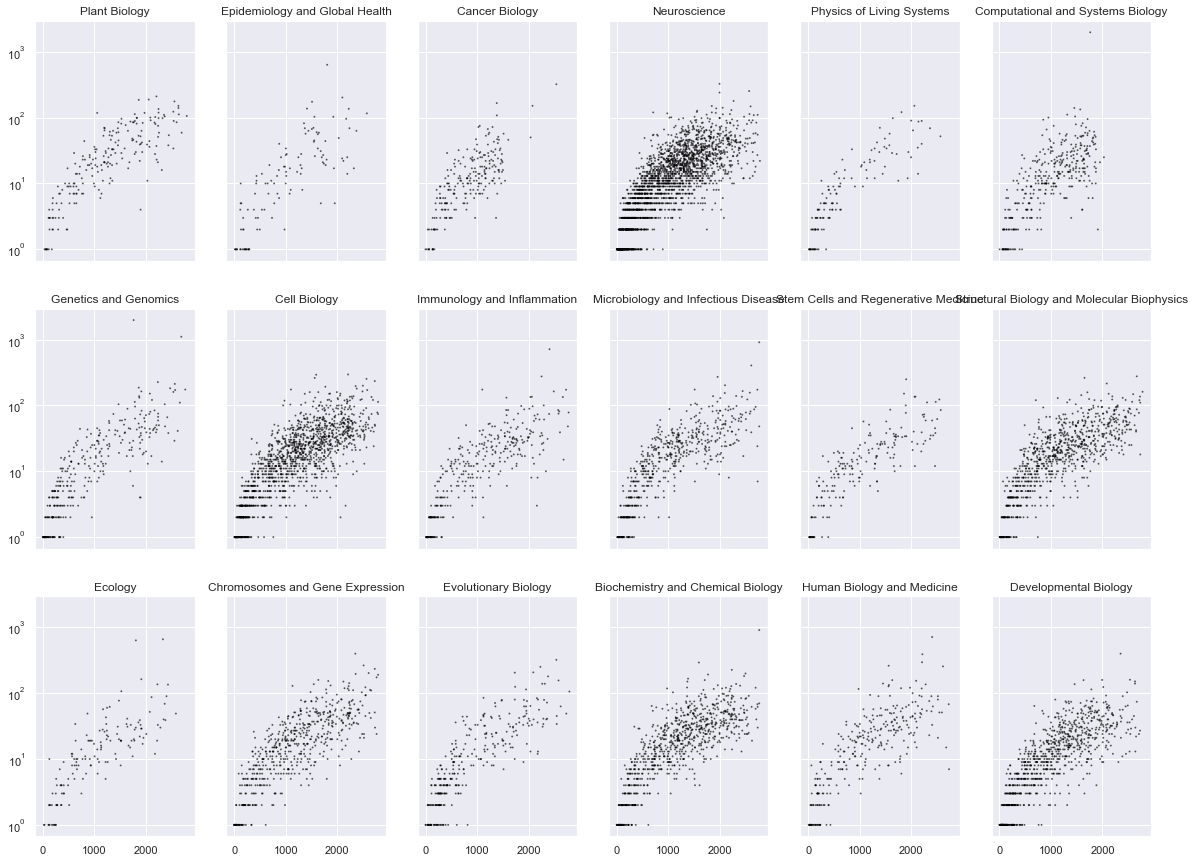

In [168]:
# plot the data within each category as a function of days since publication
# note that Elife began publishing in some fields later than in others
nr=3;nc=6
fig,axs = plt.subplots(nr,nc,sharex=True,sharey=True,figsize=(20,15))
for i,sub in enumerate(allSubjects):
    col = int(np.floor(i / nr))
    row = int(i - col*nr)
    ax = axs[row,col]
    # plot data as log+1 so 0 citations shows up on the log plot
    ax.scatter(df['daysSincePub'],df['numCitations']+1,s=df['subject_'+sub],c=(0,0,0,0.5))
    ax.set_title(sub)
    ax.set_yscale('log')

In [313]:
# sort for numCitations. It's interesting to read the reviews for low and high performaing articles
df.sort_values(by=['numCitations','numViews']) 

,numViews,numCitations,numAuthors,numOrgAuthors,numKeywords,keywords,numSubjects,subjects,articleType,noFigText,...,daysSincePub,numWords_Abstract,numWords_digest,numWords_Introduction,numWords_Results,numWords_Discussion,numWords_decisionLetter,numFigs,numMedia,numTable
56611,47,0,5,0,5,"[cohesin, shister chromatid cohesion, SMC, rep...",2,"[Biochemistry and Chemical Biology, Chromosome...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,-1,172,0,1898,4232,1832,1391,7,0,0
53367,50,0,14,0,6,"[platinum chemotherapy, lung adenocarcinoma, c...",1,[Cancer Biology],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,-1,157,295,429,4345,855,1380,7,0,0
54995,144,0,4,0,5,"[mRNA decay, RNA binding protein, mRNA decappi...",1,[Chromosomes and Gene Expression],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,0,152,0,625,2579,1484,442,7,0,0
55526,145,0,6,0,6,"[trachea, esophagus, Nkx2-1, Sox2, tracheoesop...",2,"[Developmental Biology, Genetics and Genomics]",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,-1,167,368,875,2786,1084,407,7,0,0
54434,159,0,5,0,6,"[reconstitution, Rab5, pattern formation, self...",1,[Biochemistry and Chemical Biology],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,0,155,0,1011,2169,1759,2019,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00590,27601,657,23,0,7,"[population biology, extinction risk, biodiver...",1,[Ecology],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2330,156,332,1008,1980,2581,1387,10,0,9
01202,21793,711,12,0,6,"[microbiome, inflammation, autoimmunity, metag...",2,"[Human Biology and Medicine, Immunology and In...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2407,150,306,677,2193,1558,936,6,0,3
00049,10748,908,20,0,6,[Sodium taurocholate cotransporting polypeptid...,2,"[Biochemistry and Chemical Biology, Microbiolo...",Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2764,161,458,488,3375,940,433,7,0,0
00471,30163,1101,6,0,3,"[Cas9, endonuclease, genome editing]",1,[Genetics and Genomics],Research Article,"<!doctype html>\n\n<html lang=""en"" prefix=""og:...",...,2687,137,282,450,802,446,502,3,0,0


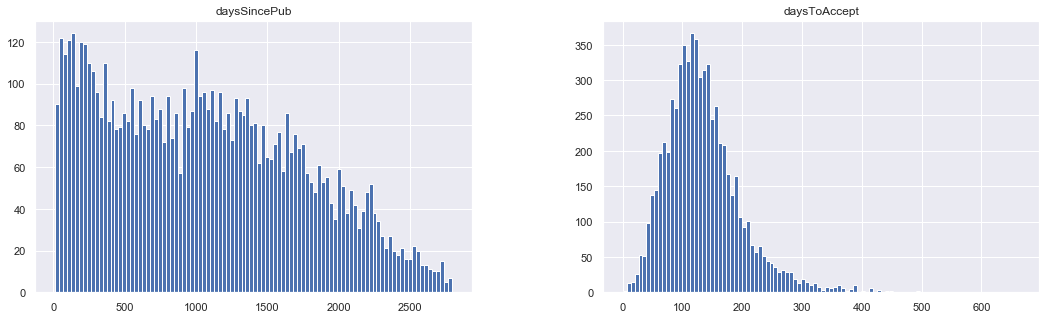

In [13]:
# histograms of days since published and days to accept
daysSincePubHist = df.hist(['daysSincePub','daysToAccept'],bins=100,figsize=(18,5))

10.867089224106946 7765.76860209673


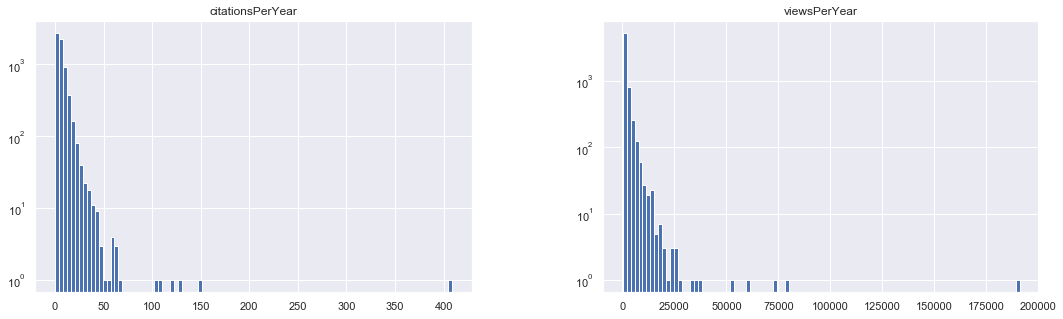

In [90]:
# Histograms of citations and views per year
print(df.citationsPerYear.var() / df.citationsPerYear.mean(),df.viewsPerYear.var()/df.viewsPerYear.mean())
disp = df.hist(['citationsPerYear','viewsPerYear'],bins=100,log=1,figsize=(18,5))

# note that the data is overdispersed with a Fano factor (variance / mean) >> 1
# However, some of this dispersion oculd be due to large effects of the factors
# Should keep this in mind and try other link / error function pairs the 
# generalized linear model used below

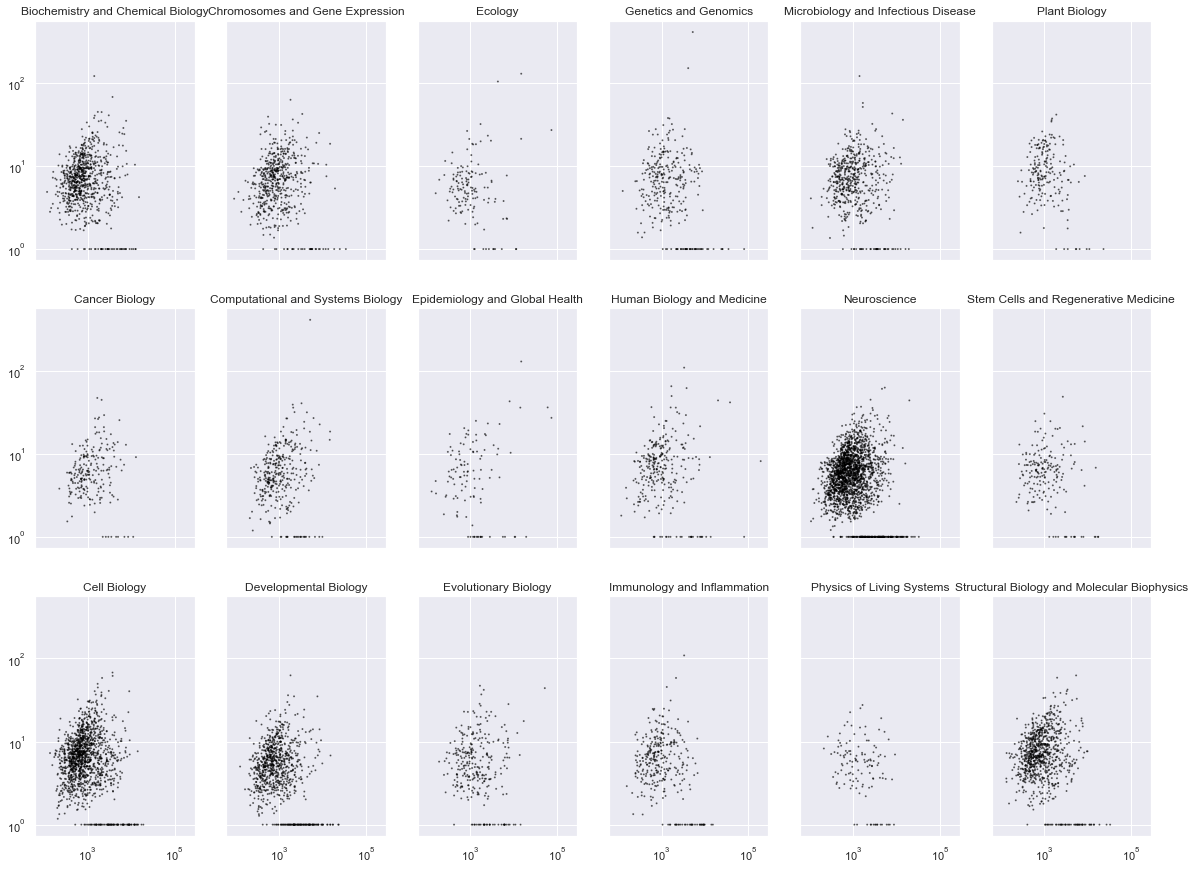

In [19]:
# replotting views and citations across subject after normalization for year
nr=3;nc=6
fig,axs = plt.subplots(nr,nc,sharex=True,sharey=True,figsize=(20,15))
for i,sub in enumerate(allSubjects):
    col = int(np.floor(i / nr))
    row = int(i - col*nr)
    ax = axs[row,col]
    ax.scatter(df['viewsPerYear']+1,df['citationsPerYear']+1,s=df['subject_'+sub],c=(0,0,0,0.5))
    ax.set_title(sub)
    ax.set_yscale('log')
    ax.set_xscale('log')

In [6]:
# run a pca to get a sense of the linear dependence across parameters.
pcaInputs = ['viewsPerYear','citationsPerYear','daysSincePub','daysToAccept','numFigs','numAuthors','numWords_total','numWords_decisionLetter']
npcs = len(pcaInputs)
df_pca = df[pcaInputs]
df_pca -= mean(df_pca,0)
df_pca /= std(df_pca,0)
covMat = np.cov(df_pca.T) # equiv to dot(df_pca.T,df_pca) / df_pca.shape[0]
eigVals,eigVecs = eigh(covMat)
eigKeys = argsort(eigVals)[::-1] # sort and reverse (they appear to be pre-sorted in reverse order by eigh, but the docs don't garauntee it)
eigVals,eugVecs = eigVals[eigKeys], eigVecs[:,eigKeys]
varExplained = eigVals / np.sum(eigVals)
lsv = dot(df_pca,eigVecs) # left singular vectors, the components

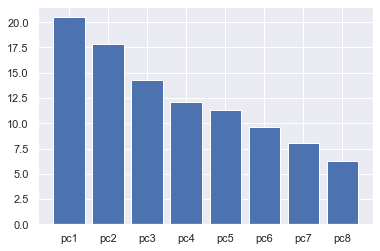

In [7]:
#project columns onto pc space
#note that none of the PCs look redundant, suggesting the same of the input factors

ypos = np.arange(len(varExplained))
plt.bar(ypos,varExplained*100)
plt.xticks(ypos,['pc'+str(i+1) for i in range(0,len(varExplained))])
plt.show()

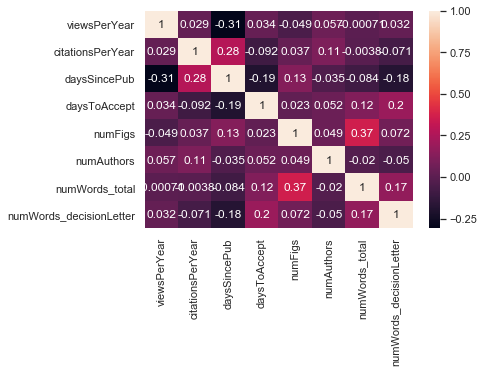

In [8]:
pcaCorr = df_pca.corr()
# mask = np.triu(np.ones_like(covMat,dtype=np.bool)) # can use as mask to hide upper triangular
sns.heatmap(df_pca.corr(),annot=True) # sns.heatmap(covMat,annot=True)

# Generalized linear model for article citations

In [20]:
# generalized linear model assessment (scoring and visualization)
# see https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py

# TweedieRegressor subclass (see next class def) calls this function during optimization. We use it to report fit progress
def tweedieRegressor_verbose_callback(Xk):
    """Called by scipi.optimize.minimize during fit iterations, passes Xk, the current fit parameter vector"""
    global glr_verbose_iter,tweedieRegressor_fitCoefProgress
    if glr_verbose_iter < 1: #first iteration
        #print('tweedieRegressor_verbose_callback storing fit results in array tweedieRegressor_fitCoefProgress')
        tweedieRegressor_fitCoefProgress = Xk
    else:
        tweedieRegressor_fitCoefProgress = np.vstack((tweedieRegressor_fitCoefProgress,Xk))
    
    #print('Iteration',glr_verbose_iter,'params',Xk) 
    glr_verbose_iter += 1
    
#subclass sklearn TweedieRegressor class so that we can get iteration information from 
#the scipi optimize routine it uses
#TweedieRegressor is itself a subclass of GeneralizedLinearRegressor which contains the fit function needing modification
#Going off sourcecode https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/linear_model/_glm/glm.py#L591
from sklearn._loss.glm_distribution import ExponentialDispersionModel,TweedieDistribution,EDM_DISTRIBUTIONS
from sklearn.linear_model._glm.link import BaseLink,IdentityLink,LogLink
from sklearn.utils import check_array, check_X_y
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.optimize import _check_optimize_result
from sklearn.linear_model._glm.glm import _y_pred_deviance_derivative
import numbers
import scipy.optimize
class TweedieRegressor_verbose(TweedieRegressor):
    
    # modifications from scikit learn's code are noted
    def fit(self, X, y, sample_weight=None):
        """Fit a Generalized Linear Model.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.
        Returns
        -------
        self : returns an instance of self.
        """
        if isinstance(self.family, ExponentialDispersionModel):
            self._family_instance = self.family
        elif self.family in EDM_DISTRIBUTIONS:
            self._family_instance = EDM_DISTRIBUTIONS[self.family]()
        else:
            raise ValueError(
                "The family must be an instance of class"
                " ExponentialDispersionModel or an element of"
                " ['normal', 'poisson', 'gamma', 'inverse-gaussian']"
                "; got (family={0})".format(self.family))

        # Guarantee that self._link_instance is set to an instance of
        # class BaseLink
        if isinstance(self.link, BaseLink):
            self._link_instance = self.link
        else:
            if self.link == 'auto':
                if isinstance(self._family_instance, TweedieDistribution):
                    if self._family_instance.power <= 0:
                        self._link_instance = IdentityLink()
                    if self._family_instance.power >= 1:
                        self._link_instance = LogLink()
                else:
                    raise ValueError("No default link known for the "
                                     "specified distribution family. Please "
                                     "set link manually, i.e. not to 'auto'; "
                                     "got (link='auto', family={})"
                                     .format(self.family))
            elif self.link == 'identity':
                self._link_instance = IdentityLink()
            elif self.link == 'log':
                self._link_instance = LogLink()
            else:
                raise ValueError(
                    "The link must be an instance of class Link or "
                    "an element of ['auto', 'identity', 'log']; "
                    "got (link={0})".format(self.link))

        if not isinstance(self.alpha, numbers.Number) or self.alpha < 0:
            raise ValueError("Penalty term must be a non-negative number;"
                             " got (alpha={0})".format(self.alpha))
        if not isinstance(self.fit_intercept, bool):
            raise ValueError("The argument fit_intercept must be bool;"
                             " got {0}".format(self.fit_intercept))
        if self.solver not in ['lbfgs']:
            raise ValueError("GeneralizedLinearRegressor supports only solvers"
                             "'lbfgs'; got {0}".format(self.solver))
        solver = self.solver
        if (not isinstance(self.max_iter, numbers.Integral)
                or self.max_iter <= 0):
            raise ValueError("Maximum number of iteration must be a positive "
                             "integer;"
                             " got (max_iter={0!r})".format(self.max_iter))
        if not isinstance(self.tol, numbers.Number) or self.tol <= 0:
            raise ValueError("Tolerance for stopping criteria must be "
                             "positive; got (tol={0!r})".format(self.tol))
        if not isinstance(self.warm_start, bool):
            raise ValueError("The argument warm_start must be bool;"
                             " got {0}".format(self.warm_start))

        family = self._family_instance
        link = self._link_instance

        X, y = check_X_y(X, y, accept_sparse=['csc', 'csr'],
                         dtype=[np.float64, np.float32],
                         y_numeric=True, multi_output=False)

        weights = _check_sample_weight(sample_weight, X)

        _, n_features = X.shape

        if not np.all(family.in_y_range(y)):
            raise ValueError("Some value(s) of y are out of the valid "
                             "range for family {0}"
                             .format(family.__class__.__name__))
        # TODO: if alpha=0 check that X is not rank deficient

        # rescaling of sample_weight
        #
        # IMPORTANT NOTE: Since we want to minimize
        # 1/(2*sum(sample_weight)) * deviance + L2,
        # deviance = sum(sample_weight * unit_deviance),
        # we rescale weights such that sum(weights) = 1 and this becomes
        # 1/2*deviance + L2 with deviance=sum(weights * unit_deviance)
        weights = weights / weights.sum()

        if self.warm_start and hasattr(self, 'coef_'):
            if self.fit_intercept:
                coef = np.concatenate((np.array([self.intercept_]),
                                       self.coef_))
            else:
                coef = self.coef_
        else:
            if self.fit_intercept:
                coef = np.zeros(n_features+1)
                coef[0] = link(np.average(y, weights=weights))
            else:
                coef = np.zeros(n_features)

        # algorithms for optimization

        if solver == 'lbfgs':
            def func(coef, X, y, weights, alpha, family, link):
                y_pred, devp = _y_pred_deviance_derivative(
                    coef, X, y, weights, family, link
                )
                dev = family.deviance(y, y_pred, weights)
                # offset if coef[0] is intercept
                offset = 1 if self.fit_intercept else 0
                coef_scaled = alpha * coef[offset:]
                obj = 0.5 * dev + 0.5 * (coef[offset:] @ coef_scaled)
                objp = 0.5 * devp
                objp[offset:] += coef_scaled
                return obj, objp

            args = (X, y, weights, self.alpha, family, link)
            
            global glr_verbose_iter #gb added as an iteration counter
            glr_verbose_iter = 0
            opt_res = scipy.optimize.minimize(
                func, coef, method="L-BFGS-B", jac=True, callback=tweedieRegressor_verbose_callback, #gb added callback
                options={
                    "maxiter": self.max_iter,
                    "iprint": (self.verbose > 0) - 1,
                    "gtol": self.tol,
                    "ftol": 1e3*np.finfo(float).eps,
                },
                args=args)
            # print(opt_res) #gb added for clarity
            self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
            coef = opt_res.x

        if self.fit_intercept:
            self.intercept_ = coef[0]
            self.coef_ = coef[1:]
        else:
            # set intercept to zero as the other linear models do
            self.intercept_ = 0.
            self.coef_ = coef

        return self

from sklearn.metrics import mean_absolute_error, mean_squared_error
def score_glm(glm, x_train, y_train, x_test, y_test, tweediePower = None):
    """takes an sklearn glm model and evaluates it based on the train/test data"""

    metrics = [
    ("D² explained", None),   # Use default scorer if it exists
    ("mean abs. error", mean_absolute_error), # from sklearn
    ("mean squared error", mean_squared_error)] # from sklearn

    if tweediePower:
        metrics += [(
        "mean Tweedie dev p={:.4f}".format(power),
        partial(mean_tweedie_deviance, power=power)
        ) for power in tweediePowers]

    res = []
    for subset_label, X, Y in [('train', x_train, y_train), ('test', x_test, y_test)]:
        for score_label, metric in metrics:
            y_pred = glm.predict(X)

            if metric is None: # try using built-in score
                if not hasattr(glm,'score'):
                    continue # no score available, continue

                score = glm.score(X,Y)
            else:
                score = metric(Y, y_pred)

            res.append({'subset':subset_label,'metric':score_label,'score':score})
    
    # nice readable format
    df_res = (pd.DataFrame(res).set_index(['metric','subset']).score.unstack(-1).round(4).loc[:,['train','test']])
        
    return (df_res, res)
    

In [83]:
# generalized linear model with log link and Poisson error dispersion
# i.e., predicted = link(X*w) with w as weights for each input X (an intercept can be added fit_intercept for link(X*w + fit_intercept))
# and a loss function to minimize deviance calculated from a Poisson distribution
# 1) choose target and inputs, normalize the latter (convert back with df_glm_stds and df_glm_means)
inputs = ['daysSincePub','daysToAccept','numFigs','numAuthors','numWords_total','numWords_decisionLetter']
inputs += ['viewsPerYear','numKeywords','numAuthors','numSubjects','numWords_digest','numMedia','numWords_Results']
targetVal = 'citationsPerYear' # to use more direct data, could use 'numCitations' and weight by 'days/year since pub' but it shouldn't matter
df_glm = df[inputs]
df_glm_means =  mean(df_glm,0)
df_glm -= df_glm_means
df_glm_stds = std(df_glm,0)
df_glm /= df_glm_stds
# 2) hyperparameters
tweediePower = 1  # one is Poisson
glmLink = 'log' # log gaurantees a positive result for any value of input variables
regularization = 0.01 # weight for regularization parameter from 0 to 1 (0 == unpenalized). Low appears to reduce overfitting with many parameters (see below)
max_iter = 1000
# 3) split into train (70% of data) and test (30% of data)
x_data = df_glm
y_data = df.loc[:,targetVal].ravel()
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3,random_state=4)
# 4) training
glm0 = TweedieRegressor_verbose(power=tweediePower,link=glmLink,max_iter=max_iter,alpha=regularization,verbose=0)
glm0.fit(x_train,y_train) # note: use regularized/normalized inputs, raw targets
# 5) assessment
(glm0_score,_) = score_glm(glm0,x_train,y_train,x_test,y_test)
print(glm0_score)
# view fit progress: note score function uses lots of attributes of glm object
glmCopy = glm0 # so make a copy and replace coefs 
trainProgress = []; testProgress = []
for coefs in tweedieRegressor_fitCoefProgress:
    glmCopy.intercept_ = coefs[0]
    glmCopy.coef_ = coefs[1:] 
    (_, scores) = score_glm(glmCopy,x_train,y_train,x_test,y_test)
    trainProgress.append({score['metric']: score['score'] for score in scores[0:3]})
    testProgress.append({score['metric']: score['score'] for score in scores[3:6]})

trainProgress = pd.DataFrame(trainProgress)
testProgress = pd.DataFrame(testProgress)

        

subset                train     test
metric                              
D² explained         0.1944   0.1841
mean abs. error      3.9052   3.8461
mean squared error  73.2387  40.6470


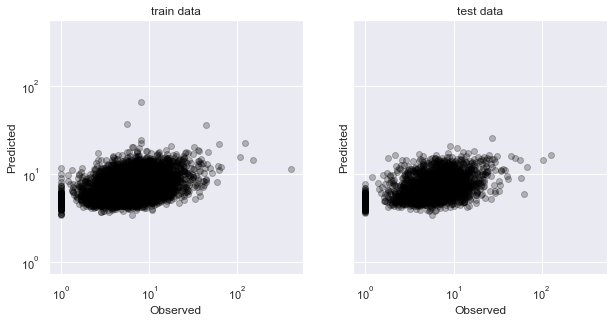

In [84]:
y_train_pred = glm0.predict(x_train)
y_test_pred = glm0.predict(x_test)
fig,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
axs[0].scatter(y_train+1,y_train_pred+1,c=(0,0,0,0.25))
axs[0].set_title('train data')
axs[1].scatter(y_test+1,y_test_pred+1,c=(0,0,0,0.25))
axs[1].set_title('test data')
minVal = np.inf; maxVal = np.NINF
for ax in axs:
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Observed')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_aspect('equal')
    minVal = np.array([ax.get_xlim()[0],ax.get_ylim()[0],minVal]).min()
    maxVal = np.array([ax.get_xlim()[1],ax.get_ylim()[1],maxVal]).max()

for ax in axs:
    ax.set_xlim((minVal,maxVal))
    ax.set_ylim((minVal,maxVal))

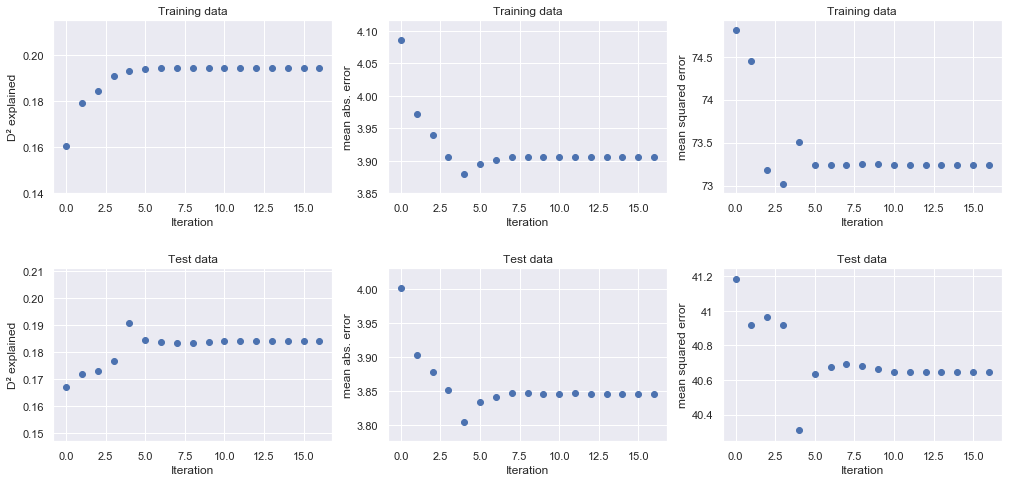

In [85]:
import matplotlib.ticker as mticker
fig,axs = plt.subplots(2,3,figsize=(17,7))
minVal = np.inf; maxVal = np.NINF
dummy_xvals = range(0,testProgress.index.stop)
offset = -0.08 #second row needs an offset
for row, frame in enumerate([trainProgress,testProgress]):
    for col, metric in enumerate(frame.columns):
        axs[row,col].scatter(dummy_xvals,frame[metric])
        axs[row,col].set_title(['Training data','Test data'][row])
        axs[row,col].set_ylabel(metric)
        axs[row,col].set_xlabel('Iteration')
        if row == 1: # adjust plots downward
            bbox = axs[row,col].get_position()
            axs[row,col].set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
        if col == 2: # adjust y axis for mean sq error
            axs[row,col].yaxis.set_major_formatter(mticker.EngFormatter())

In [86]:
# Explore hyperparameters for generalized linear model with log link and Poisson error dispersion 
# 2) hyperparameters
tweediePower = 1  # one is Poisson
glmLink = 'log' # log gaurantees a positive result for any value of input variables
 #go through a variety of regularization parameter sizes from 0 (unpenalizated) to 1 (fully penalized)
smallRegs = [0,1e-3,0.01,0.02,0.05]
regularizations = smallRegs.copy()
regularizations += list(np.around(np.linspace(0.1,0.9,9),decimals=1)) 
smallRegs.reverse()
regularizations += [1-np.array([s]).astype(np.float)[0] for s in smallRegs]
max_iter = 1000
# 3) split into train (70% of data) and test (30% of data)
x_data = df_glm
y_data = df.loc[:,targetVal].ravel()
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3,random_state=4)
# 4) training
trainResults = []; testResults = []; coefs = []; iters = {'numIters': []};
for reg in regularizations:
    glmTemp = TweedieRegressor_verbose(power=tweediePower,link=glmLink,max_iter=max_iter,alpha=reg,verbose=0)
    glmTemp.fit(x_train,y_train) # note: use regularized/normalized inputs, raw targets
    # 5) assessment
    (_,scores) = score_glm(glmTemp,x_train,y_train,x_test,y_test)
#    coefs['intercept'] = glmTemp.intercept_
    iters['numIters'] += [glmTemp.n_iter_]
    trainResults.append({'train_' + score['metric']: score['score'] for score in scores[0:3]})
    testResults.append({'test_' + score['metric']: score['score'] for score in scores[3:6]}) 
    coefs.append({**{'intercept': glmTemp.intercept_}, **{inputs[i]: coef for i, coef in enumerate(glmTemp.coef_)}})

regsAndIters = {'regularization':regularizations}; regsAndIters.update(iters)
regs = pd.DataFrame(regsAndIters).join(pd.DataFrame(trainResults))
regs = regs.join(pd.DataFrame(testResults)).join(pd.DataFrame(coefs))
#regs = regs.join(pd.DataFrame(testResults),rsuffix='_test')
regs #.sort_values(by=['D² explained','mean squared error'])

,regularization,numIters,train_D² explained,train_mean abs. error,train_mean squared error,test_D² explained,test_mean abs. error,test_mean squared error,intercept,daysSincePub,...,numFigs,numAuthors,numWords_total,numWords_decisionLetter,viewsPerYear,numKeywords,numSubjects,numWords_digest,numMedia,numWords_Results
0,0.000,17,0.194351,3.905537,73.242381,0.184021,3.846550,40.650955,1.794790,0.352335,...,-0.020015,0.052150,0.049693,-0.021273,0.058350,0.018622,0.037623,0.014159,0.024871,0.025566
1,0.001,17,0.194351,3.905508,73.242006,0.184027,3.846505,40.650557,1.794811,0.352250,...,-0.019998,0.052147,0.049645,-0.021283,0.058345,0.018614,0.037618,0.014207,0.024875,0.025595
2,0.010,17,0.194350,3.905248,73.238671,0.184081,3.846101,40.646988,1.794992,0.351489,...,-0.019844,0.052115,0.049224,-0.021367,0.058296,0.018546,0.037568,0.014635,0.024915,0.025848
3,0.020,17,0.194348,3.904963,73.235031,0.184140,3.845658,40.643056,1.795192,0.350650,...,-0.019675,0.052080,0.048771,-0.021459,0.058242,0.018470,0.037513,0.015104,0.024959,0.026114
4,0.050,17,0.194337,3.904123,73.224521,0.184309,3.844354,40.631525,1.795785,0.348168,...,-0.019179,0.051975,0.047493,-0.021730,0.058080,0.018245,0.037351,0.016474,0.025091,0.026838
5,0.100,16,0.194297,3.902782,73.208381,0.184568,3.842238,40.613341,1.796749,0.344151,...,-0.018387,0.051805,0.045591,-0.022167,0.057814,0.017878,0.037095,0.018643,0.025304,0.027839
6,0.200,13,0.194151,3.900309,73.180734,0.185001,3.838275,40.580694,1.798584,0.336520,...,-0.016911,0.051470,0.042467,-0.022976,0.057292,0.017169,0.036618,0.022593,0.025708,0.029249
7,0.300,15,0.193928,3.898160,73.158465,0.185335,3.834655,40.552811,1.800317,0.329379,...,-0.015554,0.051144,0.039968,-0.023729,0.056783,0.016482,0.036160,0.026135,0.026083,0.030117
8,0.400,14,0.193643,3.896355,73.141010,0.185577,3.831256,40.529236,1.801957,0.322655,...,-0.014304,0.050825,0.037926,-0.024413,0.056289,0.015835,0.035743,0.029309,0.026432,0.030615
9,0.500,15,0.193304,3.894865,73.127450,0.185740,3.828181,40.509562,1.803514,0.316310,...,-0.013144,0.050517,0.036209,-0.025033,0.055802,0.015218,0.035346,0.032164,0.026751,0.030867


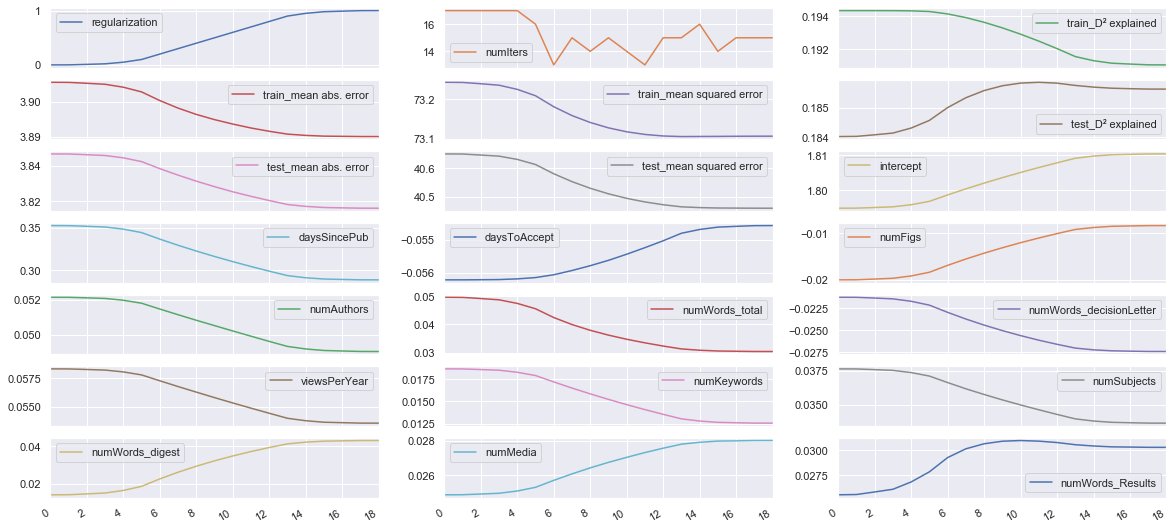

In [87]:
# observations: more regularization seems to lead to a slightly better model (intermediate has best test d square)
# importantly, parameters are robust to the degree of regularization
# daysSince pub is still the best predictor which is not surprising nor does it provide much insight. 
# given that PCA showed very few redundant parameters, the robustness to regularization is not surprising
disp = regs.plot(subplots=True,layout=(7,3),figsize=(20,10))

<Figure size 432x288 with 0 Axes>

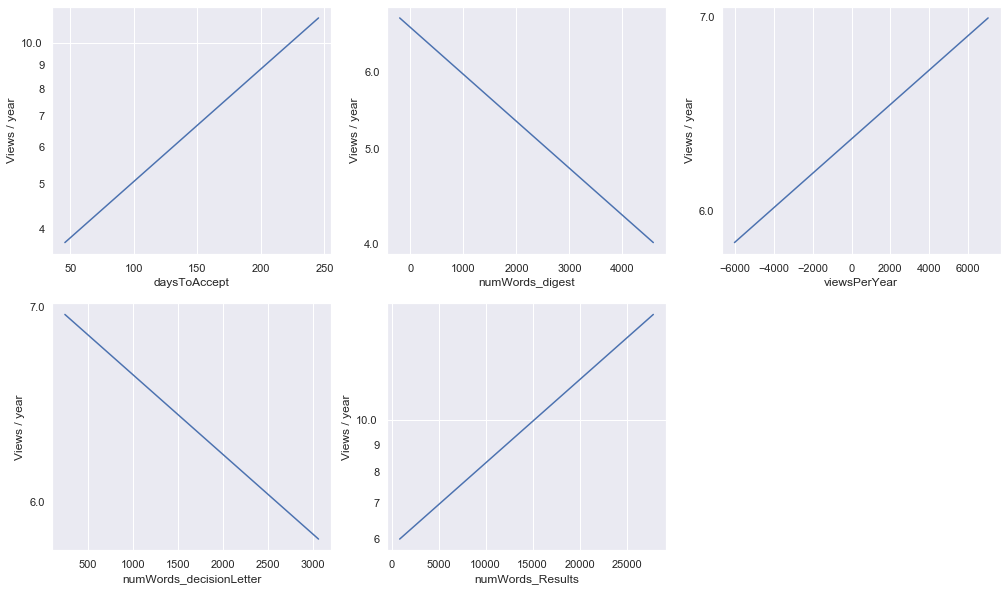

In [88]:
# get the results and scale the inputs to their actual values and plot them
# methods exist to get error bars for these (automatic in R packages)
# and statistical tests exist to determine significance of these slopes.
# note that linear on a log(y) scale is expected due to log link function
import matplotlib.ticker as mticker
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
pdp_inputs = ['daysToAccept','numWords_decisionLetter','numWords_digest','numWords_Results','viewsPerYear']
# it's convenient to get sklearn to compute the dependencies through this plot function, but the inputs are unscaled!
disp = plot_partial_dependence(glm0,x_train,pdp_inputs,feature_names=pdp_inputs)
plt.clf()
nr=2;nc=3
fig, axs = plt.subplots(nr,nc,figsize=(17,10))

for i in range(0,nr*nc):
    col = int(np.floor(i / nr))
    row = int(i - col*nr)
    if i >= len(pdp_inputs):
        fig.delaxes(axs[row,col])
        continue
    
    inp = pdp_inputs[i]
    xdata = disp.pd_results[i][1][0].copy()
    xdata *= df_glm_stds[inp]
    xdata += df_glm_means[inp]
    axs[row,col].plot(xdata.flatten(),disp.pd_results[i][0][0].flatten())
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(inp)
    axs[row,col].set_ylabel('Views / year')
    axs[row,col].yaxis.set_minor_formatter(mticker.ScalarFormatter())
    axs[row,col].yaxis.set_major_formatter(mticker.ScalarFormatter())
    axs[row,col].xaxis.set_minor_formatter(mticker.ScalarFormatter())
    axs[row,col].xaxis.set_major_formatter(mticker.ScalarFormatter())

# Conclusions 1

One of the strongest positive relationships was between daysToAccept and citations. It's interesting to speculate that reviews of these articles were more critical, leading to a longer review process and indicating poor quality. One alternative is that these articles are in non-competitive fields, providing little incentive the author to publish quickly. These possibilities could perhaps be teased apart with a sentiment analysis of the reviewer critiques.

A longer results section also appeared predictive of increased citations. This suggests it may be beneficial to encourage long-form articles, despite that "high-impact-factor" journals tend towards short form, low-word-count "reports". 

Interestingly, more views were not strongly predictive of more citations. This suggests that articles garnering populat appeal do not necessarily end up having an outsize impact on the scienfitic literature.

# Model for article views

In [66]:
# generalized linear model with log link and Poisson error dispersion
# i.e., predicted = link(X*w) with w as weights for each input X (an intercept can be added fit_intercept for link(X*w + fit_intercept))
# and a loss function to minimize deviance calculated from a Poisson distribution
# 1) choose target and inputs, normalize the latter (convert back with df_glm_stds and df_glm_means)
inputs = ['daysSincePub','daysToAccept','numFigs','numAuthors','numWords_total','numWords_decisionLetter']
inputs += ['citationsPerYear','numKeywords','numAuthors','numSubjects','numWords_digest','numMedia','numWords_Results']
targetVal = 'viewsPerYear' # to use more direct data, could use 'numCitations' and weight by 'days/year since pub' but it shouldn't matter
df_glm = df[inputs]
df_glm_means =  mean(df_glm,0)
df_glm -= df_glm_means
df_glm_stds = std(df_glm,0)
df_glm /= df_glm_stds
# 2) hyperparameters
tweediePower = 1  # one is Poisson
glmLink = 'log' # log gaurantees a positive result for any value of input variables
regularization = 0.99 # weight for regularization parameter from 0 to 1 (0 == unpenalized). High appeared to reduce overfitting with many parameters (see below)
max_iter = 1000
# 3) split into train (70% of data) and test (30% of data)
x_data = df_glm
y_data = df.loc[:,targetVal].ravel()
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3,random_state=4)
# 4) training
glm0 = TweedieRegressor_verbose(power=tweediePower,link=glmLink,max_iter=max_iter,alpha=regularization,verbose=0)
glm0.fit(x_train,y_train) # note: use regularized/normalized inputs, raw targets
# 5) assessment
(glm0_score,_) = score_glm(glm0,x_train,y_train,x_test,y_test)
print(glm0_score)
# view fit progress: note score function uses lots of attributes of glm object
glmCopy = glm0 # so make a copy and replace coefs 
trainProgress = []; testProgress = []
for coefs in tweedieRegressor_fitCoefProgress:
    glmCopy.intercept_ = coefs[0]
    glmCopy.coef_ = coefs[1:] 
    (_, scores) = score_glm(glmCopy,x_train,y_train,x_test,y_test)
    trainProgress.append({score['metric']: score['score'] for score in scores[0:3]})
    testProgress.append({score['metric']: score['score'] for score in scores[3:6]})

trainProgress = pd.DataFrame(trainProgress)
testProgress = pd.DataFrame(testProgress)

        

subset                     train          test
metric                                        
D² explained        4.228000e-01  5.462000e-01
mean abs. error     9.743583e+02  8.805383e+02
mean squared error  1.438724e+07  3.115269e+06


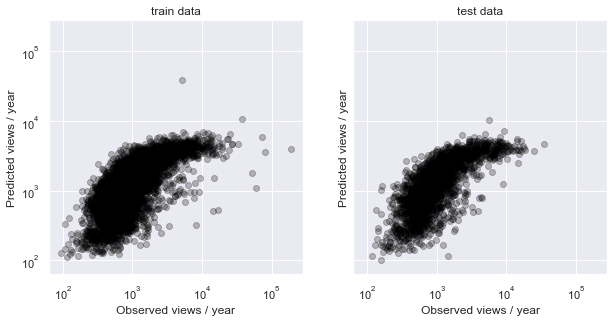

In [67]:
y_train_pred = glm0.predict(x_train)
y_test_pred = glm0.predict(x_test)
fig,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
axs[0].scatter(y_train+1,y_train_pred+1,c=(0,0,0,0.25))
axs[0].set_title('train data')
axs[1].scatter(y_test+1,y_test_pred+1,c=(0,0,0,0.25))
axs[1].set_title('test data')
minVal = np.inf; maxVal = np.NINF
for ax in axs:
    ax.set_ylabel('Predicted views / year')
    ax.set_xlabel('Observed views / year')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_aspect('equal')
    minVal = np.array([ax.get_xlim()[0],ax.get_ylim()[0],minVal]).min()
    maxVal = np.array([ax.get_xlim()[1],ax.get_ylim()[1],maxVal]).max()

for ax in axs:
    ax.set_xlim((minVal,maxVal))
    ax.set_ylim((minVal,maxVal))

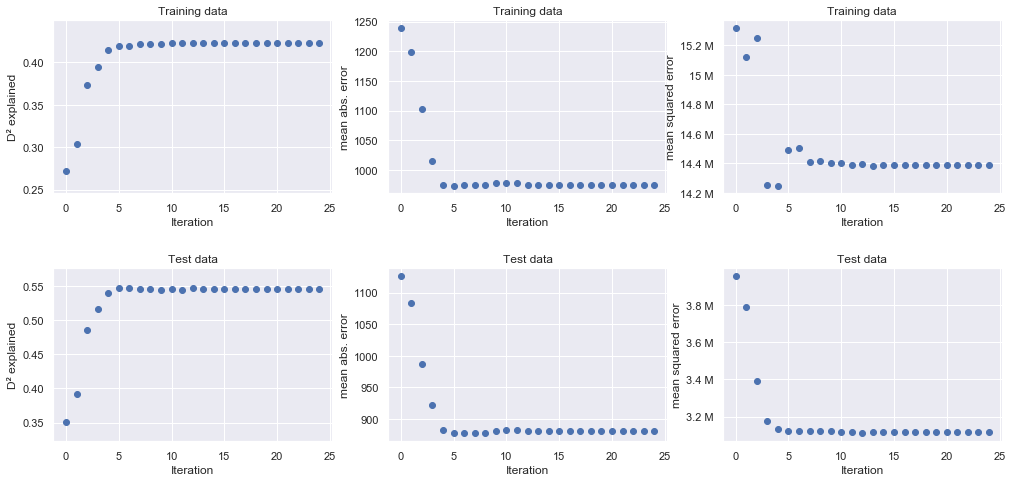

In [76]:
import matplotlib.ticker as mticker
fig,axs = plt.subplots(2,3,figsize=(17,7))
minVal = np.inf; maxVal = np.NINF
dummy_xvals = range(0,testProgress.index.stop)
offset = -0.08 #second row needs an offset
for row, frame in enumerate([trainProgress,testProgress]):
    for col, metric in enumerate(frame.columns):
        axs[row,col].scatter(dummy_xvals,frame[metric])
        axs[row,col].set_title(['Training data','Test data'][row])
        axs[row,col].set_ylabel(metric)
        axs[row,col].set_xlabel('Iteration')
        if row == 1: # adjust plots downward
            bbox = axs[row,col].get_position()
            axs[row,col].set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
        if col == 2: # adjust y axis for mean sq error
            axs[row,col].yaxis.set_major_formatter(mticker.EngFormatter())

In [55]:
# Explore hyperparameters for generalized linear model with log link and Poisson error dispersion 
# 2) hyperparameters
tweediePower = 1  # one is Poisson
glmLink = 'log' # log gaurantees a positive result for any value of input variables
 #go through a variety of regularization parameter sizes from 0 (unpenalizated) to 1 (fully penalized)
smallRegs = [0,1e-3,0.01,0.02,0.05]
regularizations = smallRegs.copy()
regularizations += list(np.around(np.linspace(0.1,0.9,9),decimals=1)) 
smallRegs.reverse()
regularizations += [1-np.array([s]).astype(np.float)[0] for s in smallRegs]
max_iter = 1000
# 3) split into train (70% of data) and test (30% of data)
x_data = df_glm
y_data = df.loc[:,targetVal].ravel()
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3,random_state=4)
# 4) training
trainResults = []; testResults = []; coefs = []; iters = {'numIters': []};
for reg in regularizations:
    glmTemp = TweedieRegressor_verbose(power=tweediePower,link=glmLink,max_iter=max_iter,alpha=reg,verbose=0)
    glmTemp.fit(x_train,y_train) # note: use regularized/normalized inputs, raw targets
    # 5) assessment
    (_,scores) = score_glm(glmTemp,x_train,y_train,x_test,y_test)
#    coefs['intercept'] = glmTemp.intercept_
    iters['numIters'] += [glmTemp.n_iter_]
    trainResults.append({'train_' + score['metric']: score['score'] for score in scores[0:3]})
    testResults.append({'test_' + score['metric']: score['score'] for score in scores[3:6]}) 
    coefs.append({**{'intercept': glmTemp.intercept_}, **{inputs[i]: coef for i, coef in enumerate(glmTemp.coef_)}})

regsAndIters = {'regularization':regularizations}; regsAndIters.update(iters)
regs = pd.DataFrame(regsAndIters).join(pd.DataFrame(trainResults))
regs = regs.join(pd.DataFrame(testResults)).join(pd.DataFrame(coefs))
#regs = regs.join(pd.DataFrame(testResults),rsuffix='_test')
regs #.sort_values(by=['D² explained','mean squared error'])

,regularization,numIters,train_D² explained,train_mean abs. error,train_mean squared error,test_D² explained,test_mean abs. error,test_mean squared error,intercept,daysSincePub,...,numFigs,numAuthors,numWords_total,numWords_decisionLetter,citationsPerYear,numKeywords,numSubjects,numWords_digest,numMedia,numWords_Results
0,0.000,25,0.422820,974.344517,1.438637e+07,0.546212,880.605093,3.114601e+06,7.100644,-0.958556,...,0.017069,0.043888,-0.155699,-0.017179,0.100627,0.018268,-0.011415,0.111942,0.071490,0.058349
1,0.001,25,0.422820,974.344531,1.438637e+07,0.546212,880.605025,3.114601e+06,7.100645,-0.958554,...,0.017069,0.043888,-0.155698,-0.017179,0.100627,0.018268,-0.011415,0.111942,0.071489,0.058348
2,0.010,25,0.422820,974.344656,1.438638e+07,0.546212,880.604410,3.114607e+06,7.100652,-0.958542,...,0.017067,0.043888,-0.155689,-0.017179,0.100627,0.018269,-0.011415,0.111938,0.071487,0.058341
3,0.020,25,0.422820,974.344794,1.438639e+07,0.546212,880.603727,3.114614e+06,7.100659,-0.958528,...,0.017065,0.043888,-0.155679,-0.017178,0.100626,0.018269,-0.011414,0.111933,0.071483,0.058333
4,0.050,25,0.422820,974.345210,1.438642e+07,0.546213,880.601678,3.114634e+06,7.100682,-0.958485,...,0.017058,0.043888,-0.155651,-0.017177,0.100624,0.018270,-0.011412,0.111918,0.071474,0.058309
5,0.100,25,0.422820,974.345901,1.438646e+07,0.546214,880.598261,3.114668e+06,7.100720,-0.958414,...,0.017047,0.043889,-0.155602,-0.017176,0.100620,0.018272,-0.011408,0.111894,0.071458,0.058270
6,0.200,25,0.422820,974.347284,1.438655e+07,0.546215,880.591426,3.114735e+06,7.100796,-0.958273,...,0.017025,0.043890,-0.155506,-0.017173,0.100613,0.018275,-0.011401,0.111846,0.071426,0.058190
7,0.300,25,0.422820,974.348688,1.438664e+07,0.546217,880.584591,3.114803e+06,7.100871,-0.958132,...,0.017003,0.043891,-0.155411,-0.017169,0.100606,0.018279,-0.011394,0.111798,0.071394,0.058111
8,0.400,25,0.422820,974.350086,1.438672e+07,0.546218,880.577756,3.114870e+06,7.100947,-0.957990,...,0.016981,0.043892,-0.155315,-0.017166,0.100598,0.018282,-0.011386,0.111750,0.071362,0.058032
9,0.500,26,0.422820,974.351504,1.438681e+07,0.546220,880.571048,3.114938e+06,7.101023,-0.957849,...,0.016959,0.043892,-0.155219,-0.017163,0.100591,0.018286,-0.011379,0.111702,0.071331,0.057953


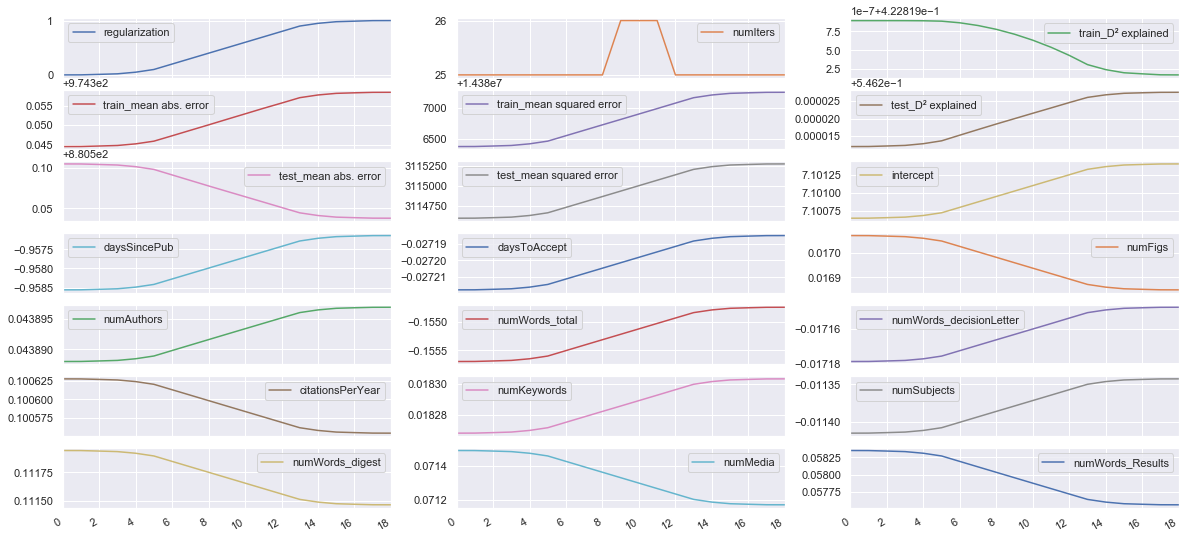

In [45]:
# observations: more regularization seems to lead to a slightly better model (intermediate has best test d square)
# importantly, parameters are robust to the degree of regularization
# daysSince pub is still the best predictor which is not surprising nor does it provide much insight. 
# given that PCA showed very few redundant parameters, the robustness to regularization is not surprising
disp = regs.plot(subplots=True,layout=(7,3),figsize=(20,10))

<Figure size 432x288 with 0 Axes>

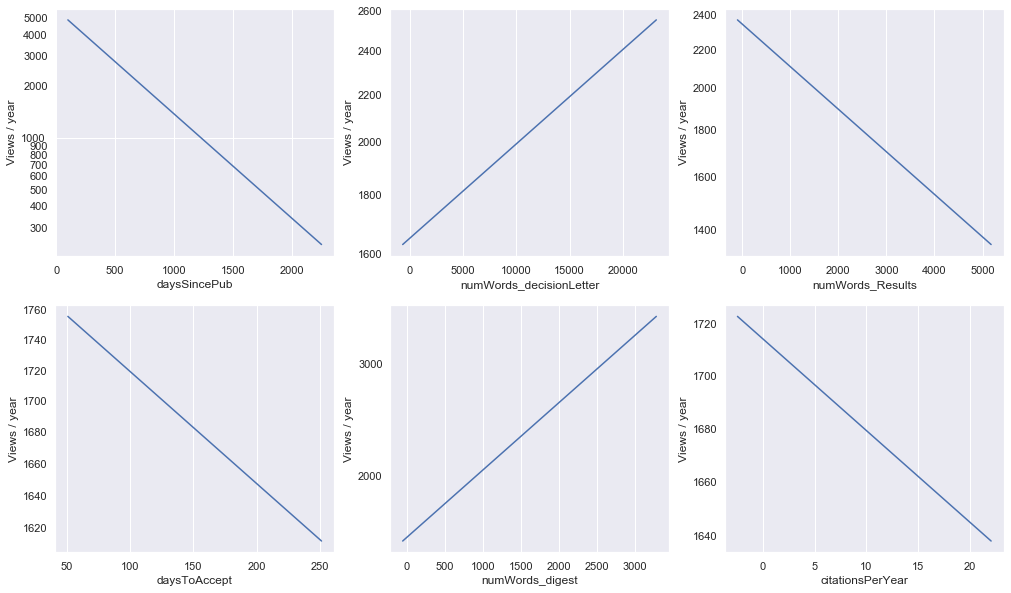

In [72]:
# get the results and scale the inputs to their actual values and plot them
# methods exist to get error bars for these (automatic in R packages)
# and statistical tests exist to determine significance of these slopes.
# note that linear on a log(y) scale is expected due to log link function
import matplotlib.ticker as mticker
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
pdp_inputs = ['daysSincePub','daysToAccept','numWords_decisionLetter','numWords_digest','numWords_Results','citationsPerYear']
# it's convenient to get sklearn to compute the dependencies through this plot function, but the inputs are unscaled!
disp = plot_partial_dependence(glm0,x_train,pdp_inputs,feature_names=pdp_inputs)
plt.clf()
nr=2;nc=3
fig, axs = plt.subplots(nr,nc,figsize=(17,10))

for i in range(0,nr*nc):
    col = int(np.floor(i / nr))
    row = int(i - col*nr)
    if i >= len(pdp_inputs):
        fig.delaxes(axs[row,col])
        continue
    
    inp = pdp_inputs[i]
    xdata = disp.pd_results[i][1][0].copy()
    xdata *= df_glm_stds[inp]
    xdata += df_glm_means[inp]
    axs[row,col].plot(xdata.flatten(),disp.pd_results[i][0][0].flatten())
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(inp)
    axs[row,col].set_ylabel('Views / year')
    axs[row,col].yaxis.set_minor_formatter(mticker.ScalarFormatter())
    axs[row,col].yaxis.set_major_formatter(mticker.ScalarFormatter())
    axs[row,col].xaxis.set_minor_formatter(mticker.ScalarFormatter())
    axs[row,col].xaxis.set_major_formatter(mticker.ScalarFormatter())

# Conclusions 2

Articles published long ago are associated with fewer views. This effect may be driven by high article viewing around the time an article is published and lower viewing later. That would produce very high viewsPerYear for recent articles and lower viewsPerYear for others. Alternatively or in conjunction, recent articles may be benefiting from increased popularity of the journal, or perhaps popularity of online viewing in general. 

As for citations, there is a strong negative relationship between daysToAccept and views. Future analysis could examine whether the lengthy review period is correlated with critical reviews. There are a number of potential confounds, including low views if fields that have long review periods. 

A longer results section also appeared predictive of increased views, as was the case for citations.

In [ ]:
# Additional notes:

# I have slightly condensed this code since originally running some of it,
# but due to the time required to download and process some of this data,
# I haven't re-run all of it. These additional dependencies may be required:

import numpy as np
from numpy import array, dot, mean, std, empty, argsort
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import TweedieRegressor
from numpy.linalg import eigh, solve
from numpy.random import randn
import pandas as pd
import re
from IPython.display import clear_output
import os
import pickle
import dill
import json
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from matplotlib.axes._axes import _log as matplotlib_axes_logger #avoid an annoying warning
matplotlib_axes_logger.setLevel('ERROR')
import inspect
import seaborn as sns
sns.set(style="darkgrid")